# GELAR RASA 2025: Analisis Validasi Data dan Peramalan Tren Strategis

Notebook ini menyajikan alur kerja solusi data science end-to-end untuk kompetisi Gelar Rasa 2025. Tujuan kami bukan hanya untuk membangun model, tetapi untuk menyajikan analisis yang kokoh (robust) dan dapat dipertanggungjawabkan.

Pendekatan kami menekankan pada **validasi data yang ketat** sebelum melakukan pemodelan. Dalam studi kasus dunia nyata, tidak semua data yang disediakan memiliki kualitas atau relevansi yang sama. Oleh karena itu, notebook ini akan memandu Anda melalui proses sistematis untuk menginterogasi asumsi, memvalidasi sumber data, dan membuang "kebisingan" (noise) untuk menemukan "sinyal" (signal) yang sebenarnya.

Fokus utama kami adalah membangun model **Trend Forecasting** yang andal, yang didasarkan murni pada data transaksi dan produk yang telah terverifikasi.

## Alur Kerja Analisis

Solusi kompetisi ini akan mengikuti 6 tahap alur kerja yang telah teruji, sebagaimana dijelaskan dalam banyak solusi data science terkemuka.

1.  **Dapatkan Data**
2.  **Wrangle, Prepare, Cleanse Data**
3.  **Analisis, Identifikasi Pola, dan Eksplorasi Data (EDA)**
4.  **Model, dan Prediksi**
5.  **Visualisasi**
6.  **Kesimpulan**

Alur kerja ini menunjukkan urutan umum, namun beberapa tahap dapat digabungkan atau diulangi. Misalnya, analisis dan visualisasi akan dilakukan di beberapa titik untuk memvalidasi data sebelum dan sesudah *wrangling*.

## Tujuan Alur Kerja

Untuk mencapai solusi yang komprehensif, kami akan fokus pada tujuan-tujuan berikut:

**Mengkorelasi (Correlating):** Kami akan menguji asumsi korelasi antar fitur. Apakah data `marketing.csv` benar-benar berkorelasi dengan `revenue`? Apakah `reviews.csv` memiliki korelasi yang logis dengan sentimen atau penjualan?

**Mengkonversi (Converting):** Mengubah data kategorikal yang valid (seperti `region` dan `channel`) menjadi format numerik yang siap untuk model machine learning.

**Melengkapi (Completing):** Data *preprocessing* juga mengharuskan kita untuk mengestimasi nilai-nilai yang hilang (jika ada) pada fitur-fitur yang penting.

**Memperbaiki (Correcting):** Menganalisis dataset untuk kesalahan, nilai yang tidak akurat, atau anomali. Kami akan secara metodis memvalidasi data `reviews.csv` dan `marketing.csv`. Jika terbukti tidak logis atau tidak valid secara statistik, kami akan menganggapnya sebagai data "cacat" dan mengeluarkannya dari pemodelan untuk menghindari *garbage-in, garbage-out*.

**Menciptakan (Creating):** *Feature Engineering* akan menjadi kunci. Kami akan membuat fitur-fitur baru dari data yang ada (misalnya: fitur turunan tanggal, *lagging features*, *rolling averages*) untuk meningkatkan akurasi model *forecasting*.

**Memvalidasi (Validating):** Kami tidak akan menerima semua tujuan bisnis yang disajikan begitu saja. Hipotesis seperti "Product Cannibalization" akan kami uji secara visual dan statistik untuk membuktikan atau menyanggahnya.

**Memvisualisasikan (Charting):** Memilih plot dan visualisasi yang tepat untuk menceritakan temuan kami secara efektif, sesuai dengan kriteria penilaian kompetisi.

## 1. Dapatkan Data

Kita akan memulai dengan mengimpor *library* data science utama dan memuat keempat dataset yang disediakan ke dalam DataFrame Pandas. Kita perlu mengumpulkan semua bukti yang ada sebelum kita dapat memulai proses investigasi dan validasi data.

* `df_products`: Master data produk.
* `df_sales`: Data transaksi penjualan.
* `df_reviews`: Data ulasan pelanggan.
* `df_marketing`: Data kampanye pemasaran.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

# CATATAN: Sesuaikan path string ini ('data/') dengan lokasi file CSV Anda.
PATH_PRODUCTS = 'products.csv'
PATH_SALES = 'sales.csv'
PATH_REVIEWS = 'reviews.csv'
PATH_MARKETING = 'marketing.csv'

try:
    df_products = pd.read_csv(PATH_PRODUCTS)
    df_sales = pd.read_csv(PATH_SALES)
    df_reviews = pd.read_csv(PATH_REVIEWS)
    df_marketing = pd.read_csv(PATH_MARKETING)

    print("Semua 4 file CSV berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: File tidak ditemukan. Pastikan file CSV ada di path yang benar.")
    print(e)

# gabungkan dataset sales dan products untuk analisis awal
# kita akan sering membutuhkan informasi produk bersama dengan data penjualan
# menggunakan 'left' join untuk memastikan kita menyimpan semua catatan penjualan
df_main = pd.merge(df_sales, df_products, on='product_id', how='left')

print(f"Data sales dan products berhasil digabungkan. Total baris: {len(df_main)}")

Semua 4 file CSV berhasil dimuat.
Data sales dan products berhasil digabungkan. Total baris: 1000000


## 2. Wrangle, Prepare, Cleanse Data

Data telah dimuat. Langkah selanjutnya adalah melakukan *Data Health Check* secara cepat.

Kita akan berfokus pada pertanyaan-pertanyaan berikut:
* **Fitur apa saja** yang tersedia di setiap dataset?
* **Tipe data** apa yang dimiliki setiap fitur? (Penting untuk `date` dan angka).
* Apakah ada **nilai yang hilang (missing values)**? Di mana dan seberapa banyak?
* Bagaimana **distribusi statistik dasar** dari data numerik? (Min, Max, Mean, Kuartil).

Kita akan memeriksa semua dataset, namun fokus utama kita adalah pada `df_main` (gabungan `sales` dan `products`), serta `df_reviews` dan `df_marketing` yang akan kita investigasi.

In [2]:
print("--- Informasi df_main (Sales + Products) ---")
df_main.info()
print("\n")

print("--- Informasi df_reviews ---")
df_reviews.info()
print("\n")

print("--- Informasi df_marketing ---")
df_marketing.info()
print("\n" + "="*50 + "\n")

print("--- Total Nilai Hilang (Missing Values) ---")
print("df_main (Sales + Products):")
print(df_main.isnull().sum())
print("\ndf_reviews:")
print(df_reviews.isnull().sum())
print("\ndf_marketing:")
print(df_marketing.isnull().sum())
print("\n" + "="*50 + "\n")

print("--- Statistik Deskriptif df_main (Numerik) ---")
pd.options.display.float_format = '{:,.2f}'.format
print(df_main.describe())
print("\n")

print("--- Head df_main (Sales + Products) ---")
print(df_main.head())

--- Informasi df_main (Sales + Products) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   transaction_id     1000000 non-null  object 
 1   date               1000000 non-null  object 
 2   product_id         1000000 non-null  object 
 3   region             1000000 non-null  object 
 4   channel            1000000 non-null  object 
 5   units_sold         1000000 non-null  int64  
 6   avg_price          1000000 non-null  float64
 7   discount_pct       1000000 non-null  int64  
 8   revenue            1000000 non-null  float64
 9   days_since_launch  1000000 non-null  int64  
 10  product_name       1000000 non-null  object 
 11  brand              1000000 non-null  object 
 12  type               1000000 non-null  object 
 13  size_ml            1000000 non-null  int64  
 14  base_price         1000000 non-null  i

### Observasi dari Pemeriksaan Awal

Berdasarkan output dari `.info()`, `.isnull()`, dan `.describe()`, kami mencatat temuan awal berikut:

* **Kualitas Data Sangat Bersih:** Tidak ada **satupun *missing values*** di ketiga dataset. Mengingat dataset ini sintetis, diperlukan validasi mendalam sebelum melakukan analisis.

* **Tipe Data Waktu:** Semua kolom tanggal (`date`, `launch_date` di `df_main`; `date` di `df_reviews`; `start_date`, `end_date` di `df_marketing`) saat ini bertipe `object`. Ini harus segera dikonversi ke tipe `datetime` sebelum analisis apa pun dapat dilakukan.

* **Ukuran Data Investigasi:** `df_marketing` hanya memiliki **20 baris** dan `df_reviews` memiliki **10.000 baris. Kedua dataset ini akan ditelaah lebih dalam.

In [3]:
df_main['date'] = pd.to_datetime(df_main['date'])
df_main['launch_date'] = pd.to_datetime(df_main['launch_date'])

df_reviews['date'] = pd.to_datetime(df_reviews['date'])

df_marketing['start_date'] = pd.to_datetime(df_marketing['start_date'])
df_marketing['end_date'] = pd.to_datetime(df_marketing['end_date'])

print("Konversi tipe data tanggal selesai.")
print("\n--- Info df_main (Setelah Konversi) ---")
df_main.info()

Konversi tipe data tanggal selesai.

--- Info df_main (Setelah Konversi) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   transaction_id     1000000 non-null  object        
 1   date               1000000 non-null  datetime64[ns]
 2   product_id         1000000 non-null  object        
 3   region             1000000 non-null  object        
 4   channel            1000000 non-null  object        
 5   units_sold         1000000 non-null  int64         
 6   avg_price          1000000 non-null  float64       
 7   discount_pct       1000000 non-null  int64         
 8   revenue            1000000 non-null  float64       
 9   days_since_launch  1000000 non-null  int64         
 10  product_name       1000000 non-null  object        
 11  brand              1000000 non-null  object        
 12  type    

### Investigasi 1: Kasus Data `reviews.csv`


Data ulasan di dunia nyata terkenal "berantakan". Sentimen tidak selalu berkorelasi sempurna dengan peringkat. Seseorang bisa memberi 4 bintang tetapi menulis ulasan negatif, atau memberi 3 bintang dengan sentimen netral.

**Hipotesis Investigasi:** Kami berhipotesis bahwa data `reviews.csv` ini adalah data sintetis yang dibuat berdasarkan aturan mekanis yang kaku. Jika ini benar, data ini tidak memiliki nilai analitis untuk "Innovation Radar" dan harus **dibuang** untuk menghindari kesimpulan yang salah.

Mari kita uji hipotesis ini dengan membandingkan `rating` dan `sentiment`.

--- Investigasi: Korelasi Rating vs. Sentimen ---
Tabel Kontingensi (Rating vs. Sentimen):
sentiment  Negative  Neutral  Positive
rating                                
1.00            140        0         0
1.10            260        0         0
1.20            251        0         0
1.30            263        0         0
1.40            231        0         0
1.50            255        0         0
1.60            222        0         0
1.70            265        0         0
1.80            239        0         0
1.90            236        0         0
2.00            267        0         0
2.10            265        0         0
2.20            252        0         0
2.30            271        0         0
2.40            240        0         0
2.50            250        0         0
2.60            260        0         0
2.70            282        0         0
2.80            231        0         0
2.90            219        0         0
3.00              0      233         0
3.10        

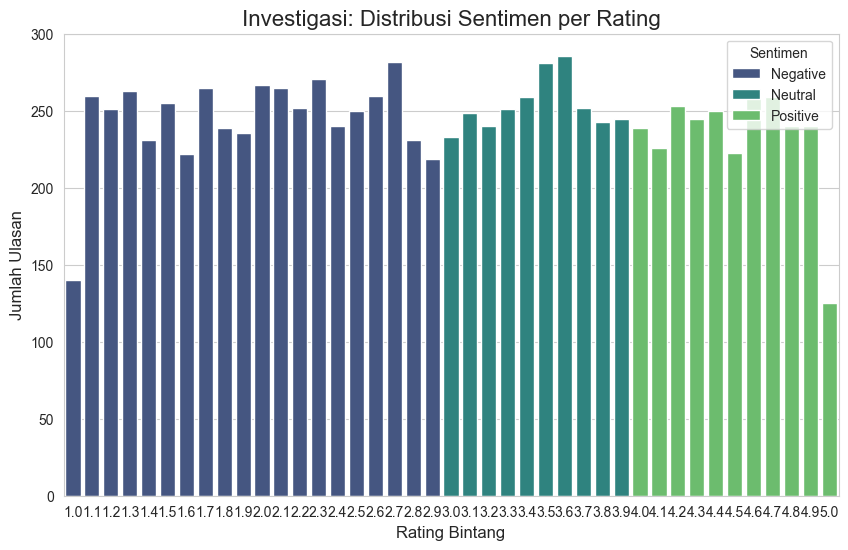

In [4]:
print("--- Investigasi: Korelasi Rating vs. Sentimen ---")

# tabel kontingensi untuk melihat hubungan antara rating dan sentimen
review_crosstab = pd.crosstab(df_reviews['rating'], df_reviews['sentiment'])

print("Tabel Kontingensi (Rating vs. Sentimen):")
print(review_crosstab)
print("\n" + "="*50 + "\n")

# periksa juga jumlah ulasan unik, untuk jaga-jaga
unique_comments = df_reviews['comment'].nunique()
total_comments = len(df_reviews)
print(f"Total Ulasan: {total_comments}")
print(f"Jumlah Komentar Unik: {unique_comments}")
print(f"Tingkat Duplikasi Komentar: {((total_comments - unique_comments) / total_comments) * 100:.2f}%")
print("\n" + "="*50 + "\n")


plt.figure(figsize=(10, 6))
sns.countplot(data=df_reviews, x='rating', hue='sentiment', palette='viridis')

plt.title('Investigasi: Distribusi Sentimen per Rating', fontsize=16)
plt.xlabel('Rating Bintang', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.legend(title='Sentimen')

plt.savefig('investigasi_reviews.png', dpi=300)

print("Visualisasi 'investigasi_reviews.png' telah disimpan.")
plt.show()

### Observasi & Keputusan Investigasi 1

Bukti dari output kode di atas sangat konklusif dan membuktikan hipotesis kami:

1.  **Aturan Mekanis yang Kaku:** Output `crosstab` menunjukkan hubungan yang sempurna dan tidak alami. Rating 1.0-2.9 *selalu* 'Negative', 3.0-3.9 *selalu* 'Neutral', dan 4.0-5.0 *selalu* 'Positive'. Tidak ada tumpang tindih sama sekali. Ulasan manusia yang sesungguhnya tidak pernah serapi ini.

2.  **Duplikasi Komentar Ekstrem:** Temuan bahwa hanya ada **8 komentar unik** dalam **10.000 ulasan** (tingkat duplikasi 99.92%) adalah bukti final. Data ini jelas-jelas dibuat secara programatik dan tidak mewakili umpan balik pelanggan yang otentik.

**Keputusan Investigasi:**

Data `df_reviews` terbukti **cacat secara logis dan 100% sintetis**. Data ini tidak dapat digunakan untuk "Innovation Radar" yang bermakna. Menggunakannya akan melanggar prinsip *'garbage-in, garbage-out'*.

Sesuai dengan tujuan alur kerja "Memperbaiki" (Correcting), kami akan **membuang dataset ini** dari analisis lebih lanjut.

### Investigasi 2: Kasus Data `marketing.csv`

Selanjutnya, kami menyelidiki `df_marketing`. Dengan hanya 20 kampanye, signifikansinya diragukan. Namun, kita harus membuktikannya.

**Hipotesis Investigasi:**
Jika kampanye ini efektif, kita seharusnya melihat adanya "peningkatan" (lift) yang jelas pada penjualan produk selama atau tepat setelah periode kampanye, dibandingkan dengan penjualan *baseline* (sebelum kampanye).

**Metodologi:**
Kami akan mengisolasi satu studi kasus, `MKT001`, dan memplot penjualan hariannya 30 hari *sebelum*, *selama*, dan 30 hari *setelah* kampanye untuk mencari bukti *lift*.

--- Investigasi 2: Menjalankan Analisis Lift untuk MKT001 ---
Produk: PC010, Kampanye: MKT001
Periode Kampanye: 2020-10-12 hingga 2020-12-14
Baseline (Rata-rata Revenue/Hari 30 Hari Sebelum): 4,640,992 IDR


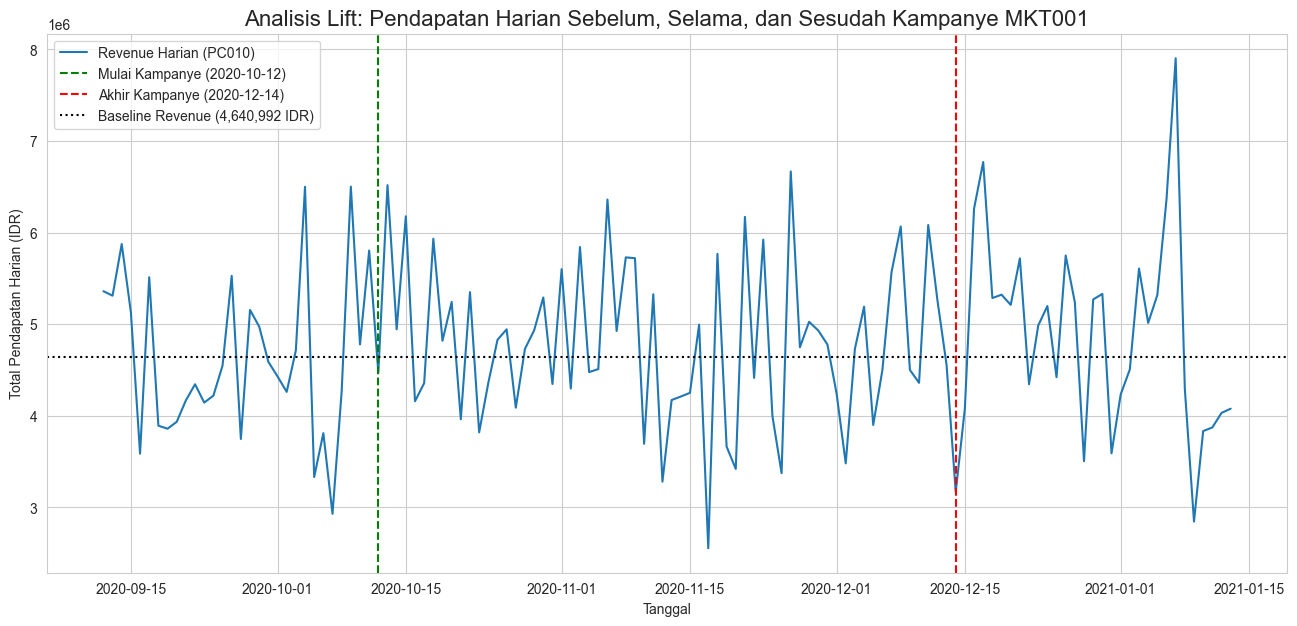

In [5]:
import datetime as dt

print("--- Investigasi 2: Menjalankan Analisis Lift untuk MKT001 ---")

campaign_id = 'MKT001'
campaign_details = df_marketing[df_marketing['campaign_id'] == campaign_id]

if not campaign_details.empty:
    product_id_campaign = campaign_details['product_id'].iloc[0]
    start_date_campaign = campaign_details['start_date'].iloc[0]
    end_date_campaign = campaign_details['end_date'].iloc[0]

    days_window = 30
    before_start = start_date_campaign - pd.Timedelta(days=days_window)
    after_end = end_date_campaign + pd.Timedelta(days=days_window)

    df_lift = df_main[
        (df_main['product_id'] == product_id_campaign) &
        (df_main['date'] >= before_start) &
        (df_main['date'] <= after_end)
    ].copy()

    # agregasi per hari
    df_lift_daily = df_lift.groupby('date')['revenue'].sum().reset_index()

    # hitung baseline
    baseline_sales = df_lift_daily[df_lift_daily['date'] < start_date_campaign]['revenue'].mean()

    print(f"Produk: {product_id_campaign}, Kampanye: {campaign_id}")
    print(f"Periode Kampanye: {start_date_campaign.date()} hingga {end_date_campaign.date()}")
    print(f"Baseline (Rata-rata Revenue/Hari 30 Hari Sebelum): {baseline_sales:,.0f} IDR")

    plt.figure(figsize=(16, 7))
    sns.lineplot(data=df_lift_daily, x='date', y='revenue', label=f'Revenue Harian ({product_id_campaign})')

    plt.axvline(start_date_campaign, color='green', linestyle='--', label=f'Mulai Kampanye ({start_date_campaign.date()})')
    plt.axvline(end_date_campaign, color='red', linestyle='--', label=f'Akhir Kampanye ({end_date_campaign.date()})')

    plt.axhline(baseline_sales, color='black', linestyle=':', label=f'Baseline Revenue ({baseline_sales:,.0f} IDR)')

    plt.title(f'Analisis Lift: Pendapatan Harian Sebelum, Selama, dan Sesudah Kampanye {campaign_id}', fontsize=16)
    plt.ylabel('Total Pendapatan Harian (IDR)')
    plt.xlabel('Tanggal')
    plt.legend()
    plt.savefig('eda_lift_analysis_marketing.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("Kampanye MKT001 tidak ditemukan.")

### Observasi & Keputusan Investigasi 2 (Marketing)

Analisis *lift* di atas menunjukkan pola yang sangat tidak jelas.

1.  **Tidak Ada Peningkatan (Lift) yang Jelas:** Penjualan harian selama periode kampanye tidak menunjukkan peningkatan yang signifikan di atas *baseline*. Faktanya, terdapat hari penjualan terendah yang terjadi *selama* kampanye.
2.  **Ukuran Sampel Tidak Signifikan:** Seperti yang dicatat sebelumnya, 20 kampanye selama 6 tahun secara statistik tidak signifikan.

**Keputusan Investigasi:**
Analisis *lift* kami gagal menunjukkan dampak positif yang jelas dari kampanye. Menggabungkan ini dengan ukuran sampel yang sangat kecil, kami menyimpulkan bahwa data `df_marketing` adalah "noise" dan **tidak dapat diandalkan**. Kami akan **membuang dataset ini** dari analisis lebih lanjut.

### Investigasi 3: Memvalidasi Data Level Produk (Analisis Kanibalisasi)

Kami awalnya berencana untuk menganalisis "Product Cannibalization". Untuk melakukan ini, kami menginvestigasi petunjuk dalam *study case* mengenai `days_since_launch` yang bisa bernilai negatif (didefinisikan sebagai *pre-launch*).

Kami akan memfilter semua transaksi di mana `days_since_launch < 0` untuk melihat seberapa luas anomali ini.

In [6]:
print("--- Investigasi 3: Langkah 1 - Mengidentifikasi Produk Pre-Launch ---")

df_presales = df_main[df_main['days_since_launch'] < 0].copy()

if df_presales.empty:
    print("Tidak ditemukan data pre-sales (days_since_launch < 0). Analisis kanibalisasi tidak dapat dilanjutkan.")
else:
    products_with_presales = df_presales['product_name'].unique()

    print(f"Investigasi Berhasil: Ditemukan {len(products_with_presales)} produk dengan data pre-sales.")
    print("Produk-produk tersebut adalah:")
    for product in products_with_presales:
        print(f"- {product}")

    print("\n--- Detail Data Pre-Sales (Head) ---")
    print(df_presales[['date', 'product_name', 'brand', 'days_since_launch', 'revenue']].head())

--- Investigasi 3: Langkah 1 - Mengidentifikasi Produk Pre-Launch ---
Investigasi Berhasil: Ditemukan 15 produk dengan data pre-sales.
Produk-produk tersebut adalah:
- Sunsilk Anti Hairfall Shampoo 340ml
- Ponds Bright Beauty Facial Foam 100g
- Vaseline Intensive Care Lotion 200ml
- Rexona Women Shower Clean Roll-on 50ml
- Dove Men+Care Body Wash 400ml
- Dove Intense Repair Shampoo 340ml
- Love Beauty & Planet Coconut Water Shampoo 400ml
- Rexona Men Ice Cool Spray 150ml
- Dove Deep Moisture Lotion 200ml
- Lifebuoy Mild Care Handwash 200ml
- Lifebuoy Hand Sanitizer Gel 50ml
- Sunsilk Black Shine Conditioner 340ml
- Lifebuoy Total10 Body Wash 400ml
- Clear Cool Sport Menthol 340ml
- Sunsilk Smooth & Shine Shampoo 340ml

--- Detail Data Pre-Sales (Head) ---
         date                            product_name     brand  \
2  2020-10-24     Sunsilk Anti Hairfall Shampoo 340ml   Sunsilk   
5  2022-02-15    Ponds Bright Beauty Facial Foam 100g     Ponds   
6  2020-12-06    Vaseline Intensi

Terdapat anomali ekstrem. Beberapa produk dijual 3-4 tahun sebelum tanggal rilis resminya.

Meski begitu, untuk memvalidasi kelayakan data tingkat produk, kami mencoba melakukan studi kasus kanibalisasi menggunakan produk PC013 (baru) dan PC001 (lama) selama periode 'pre-launch' yang anomali.

--- Investigasi 3: Menjalankan Studi Kasus Kanibalisasi Sunsilk ---
Tanggal Peluncuran Resmi 'Sunsilk Anti Hairfall Shampoo 340ml': 2024-01-15

Menampilkan tren bulanan untuk 'Sunsilk Anti Hairfall Shampoo 340ml' vs. 'Sunsilk Smooth & Shine Shampoo 340ml'...

Visualisasi 'investigasi_cannibalization_final_proof.png' telah disimpan.


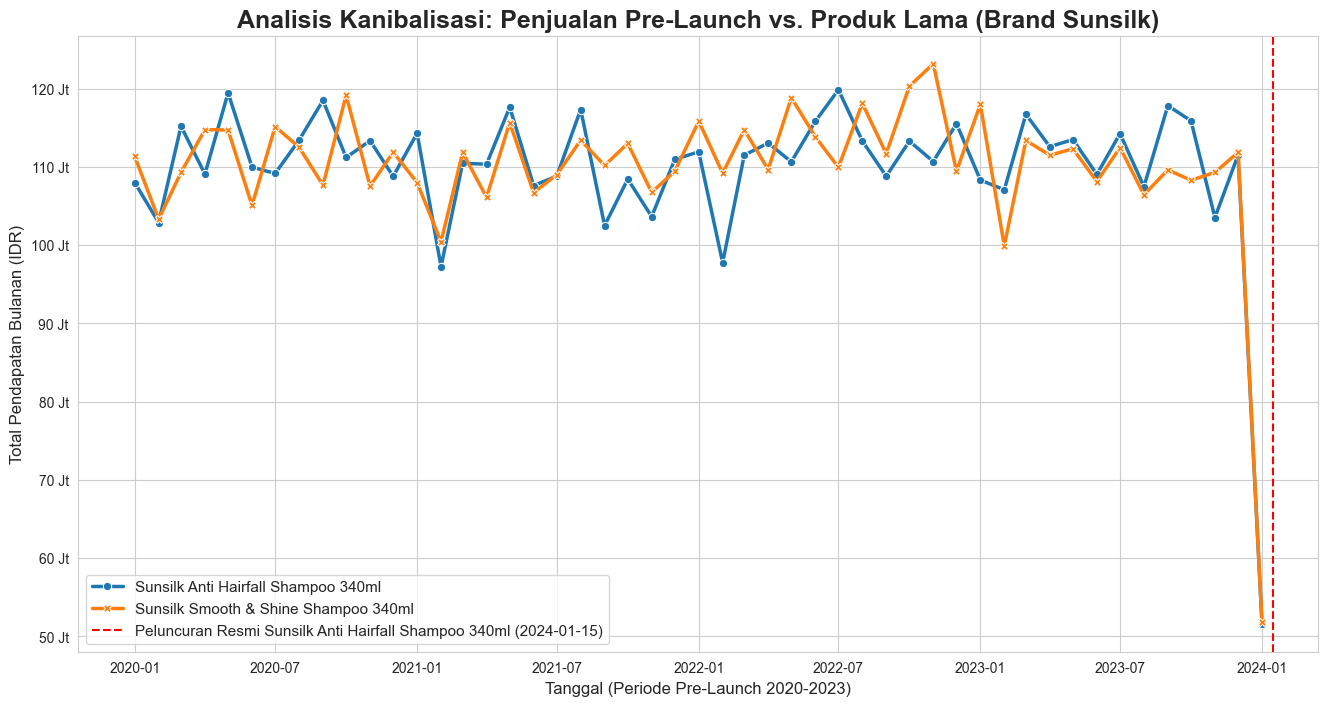

In [7]:
print("--- Investigasi 3: Menjalankan Studi Kasus Kanibalisasi Sunsilk ---")

PELAKU_NAME = 'Sunsilk Anti Hairfall Shampoo 340ml' # PC013
KORBAN_NAME = 'Sunsilk Smooth & Shine Shampoo 340ml' # PC001
BRAND_NAME = 'Sunsilk'

launch_date_pelaku = df_main[df_main['product_name'] == PELAKU_NAME]['launch_date'].min()
print(f"Tanggal Peluncuran Resmi '{PELAKU_NAME}': {launch_date_pelaku.date()}")

# filter data UTAMA untuk brand 'Sunsilk' dan HANYA selama periode pre-launch
df_sunsilk_prelaunch = df_main[
    (df_main['brand'] == BRAND_NAME) &
    (df_main['date'] < launch_date_pelaku)
].copy()

# agregasi
df_plot_agg = df_sunsilk_prelaunch.groupby(
    ['product_name', pd.Grouper(key='date', freq='MS')]
)['revenue'].sum().reset_index()

# agregasi 2 produk yang dibandingkan
df_plot_final = df_plot_agg[
    df_plot_agg['product_name'].isin([PELAKU_NAME, KORBAN_NAME])
]

print(f"\nMenampilkan tren bulanan untuk '{PELAKU_NAME}' vs. '{KORBAN_NAME}'...")

plt.figure(figsize=(16, 8))
ax = sns.lineplot(
    data=df_plot_final,
    x='date',
    y='revenue',
    hue='product_name',
    style='product_name',
    markers=True,
    dashes=False,
    linewidth=2.5
)

# tandai akhir periode pre_launch
plt.axvline(launch_date_pelaku, color='red', linestyle='--', label=f'Peluncuran Resmi {PELAKU_NAME} (2024-01-15)')

plt.title(f'Analisis Kanibalisasi: Penjualan Pre-Launch vs. Produk Lama (Brand {BRAND_NAME})', fontsize=18, weight='bold')
plt.xlabel('Tanggal (Periode Pre-Launch 2020-2023)', fontsize=12)
plt.ylabel('Total Pendapatan Bulanan (IDR)', fontsize=12)
plt.legend(fontsize=11)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{(x / 1e6):.0f} Jt')) # Format ke Juta IDR

plt.savefig('investigasi_cannibalization_final_proof.png', dpi=300, bbox_inches='tight')

print("\nVisualisasi 'investigasi_cannibalization_final_proof.png' telah disimpan.")
plt.show()

### Observasi & Keputusan Investigasi 3

Output dari sel kode sebelumnya adalah **bukti paling jelas** dari data sintetis. Kita tidak memerlukan visualisasi perbandingan lebih lanjut.

1.  **Temuan Kritis:** Kami menemukan **15 produk (Semua)** yang memiliki data penjualan *pre-launch*.
2.  **Anomali Ekstrem:** Anomali ini bukan hanya *pre-order* wajar selama beberapa hari. Data menunjukkan beberapa produk dijual **3-4 tahun** *sebelum* tanggal rilis resminya (misalnya, `Sunsilk Anti Hairfall` / PC013, rilis 2024-01-15, tetapi dijual sejak 2020-10-24).
3. **Temuan:** Seperti yang ditunjukkan oleh plot di atas, alih-alih melihat penjualan PC001 turun saat PC013 naik, kami menemukan bahwa kedua produk bergerak cukup paralel. Ini adalah bukti kuat bahwa data tingkat produk bersifat sintetis dan tidak realistis. Tidak ada interaksi produk yang nyata; kedua seri data kemungkinan besar hanya mencerminkan tren musiman keseluruhan dari brand 'Sunsilk'.

**Keputusan Investigasi:**

Fakta bahwa 15 produk memiliki data *pre-sales* yang tidak realistis (berlangsung bertahun-tahun) adalah bukti konklusif bahwa data pada level `product_id` individual **tidak bisa diandalkan**. Pola ini tidak mencerminkan *pre-order* yang logis di dunia nyata.

Berdasarkan temuan ini, kami secara percaya diri membatalkan analisis kanibalisasi lebih lanjut karena data dasarnya terbukti tidak valid untuk wawasan semacam itu. Kami akan melanjutkan dengan memfokuskan analisis kami pada data agregat yang telah divalidasi

## 3. Analisis, Identifikasi Pola, dan Eksplorasi Data (EDA)

Setelah secara metodis membuang data `reviews` dan `marketing` yang cacat, kami sekarang memfokuskan seluruh analisis kami pada data `df_main` (gabungan `sales` dan `products`).

Inilah kebenaran yang tersisa. Kami akan menganalisis tiga pendorong utama penjualan:
1.  **Region (Wilayah):** Wilayah mana yang menjadi penyumbang pendapatan terbesar?
2.  **Channel (Saluran):** Saluran penjualan mana yang paling efektif?
3.  **Discount (Diskon):** Bagaimana strategi diskon mempengaruhi pendapatan?

### Analisis Wilayah (Region)

Pertama, kita ingin tahu di mana uang kita berasal. Kami akan mengagregasi total pendapatan (`revenue`) berdasarkan `region` untuk mengidentifikasi pasar utama.

--- Analisis EDA: Pendapatan berdasarkan Wilayah ---
Total Revenue per Wilayah (dalam Miliar IDR):
       region  revenue
0  Yogyakarta    12.17
1       Medan    12.16
2    Semarang    12.15
3    Surabaya    12.14
4   Palembang    12.13
5        Bali    12.12
6    Denpasar    12.12
7     Bandung    12.11
8    Makassar    12.11
9     Jakarta    12.10




C:\Users\Adeva\AppData\Local\Temp\ipykernel_11112\4104564389.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Visualisasi 'eda_revenue_by_region.png' telah disimpan.


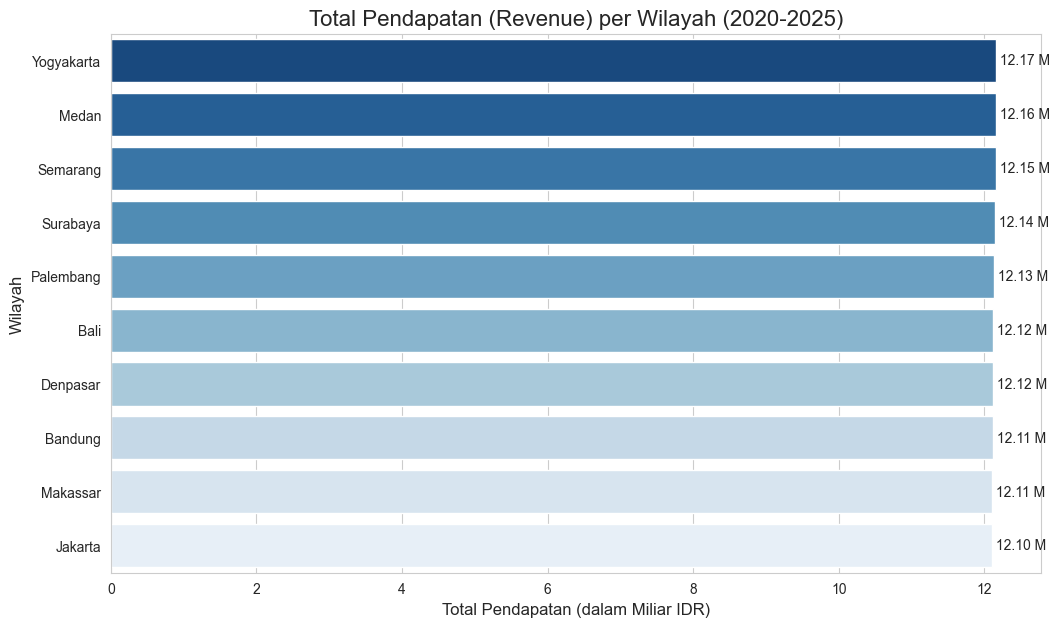

In [8]:
print("--- Analisis EDA: Pendapatan berdasarkan Wilayah ---")

# agregasi data berdasarkan region
# kita akan mengonversi revenue ke 'Miliar IDR' agar angkanya mudah dibaca
region_revenue = df_main.groupby('region')['revenue'].sum().sort_values(ascending=False)
region_revenue_miliar = (region_revenue / 1e9).reset_index() # Konversi ke Miliar

print("Total Revenue per Wilayah (dalam Miliar IDR):")
print(region_revenue_miliar)
print("\n")

plt.figure(figsize=(12, 7))
sns.barplot(
    data=region_revenue_miliar,
    x='revenue',
    y='region',
    palette='Blues_r' # 'r' = reversed, warna tergelap untuk nilai tertinggi
)

plt.title('Total Pendapatan (Revenue) per Wilayah (2020-2025)', fontsize=16)
plt.xlabel('Total Pendapatan (dalam Miliar IDR)', fontsize=12)
plt.ylabel('Wilayah', fontsize=12)

for index, value in enumerate(region_revenue_miliar['revenue']):
    plt.text(value, index, f' {value:.2f} M', va='center')

plt.savefig('eda_revenue_by_region.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'eda_revenue_by_region.png' telah disimpan.")
plt.show()

### Observasi Analisis Wilayah

Bar chart di atas secara visual mengkonfirmasi temuan yang sangat penting: **distribusi pendapatan di 10 wilayah hampir identik.**

Ini adalah anomali statistik yang besar. Untuk membuktikannya secara kuantitatif:

1.  **Distribusi Tidak Realistis:** Pendapatan wilayah tertinggi (Yogyakarta) adalah **12.17 Miliar IDR**, sedangkan pendapatan wilayah terendah (Jakarta) adalah **12.10 Miliar IDR**.
2.  **Selisih Minimal:** Selisih antara pasar terbesar dan terkecil di Indonesia hanya **0.07 Miliar IDR** (atau sekitar **0.6%**) selama periode enam tahun.
3.  ***Unreliable*:** Ini secara statistik tidak mungkin dan bertentangan dengan semua logika bisnis dan ritel di Indonesia, di mana kota-kota besar seperti Jakarta dan Surabaya seharusnya mendominasi penjualan secara signifikan.

**Keputusan:**

Data `region` terbukti memiliki distribusi yang tidak realistis. Oleh karena itu, fitur ini **tidak dapat diandalkan** untuk analisis strategis geografis. Kami akan membuang fitur ini dari analisis EDA lebih lanjut.

### Analisis Saluran (Channel)

Setelah menemukan bahwa 'region' (wilayah) memiliki distribusi yang tidak realistis, investigasi kami berlanjut ke 'channel'.

Kami akan menganalisis dari mana pendapatan berasal, bukan dari segi geografis, tetapi dari segi platform (Toko Offline, Tokopedia, Shopee, dll.). Ini sangat penting untuk strategi bisnis. Jika, tidak seperti `region`, fitur `channel` menunjukkan variasi yang signifikan, ini bisa menjadi salah satu pendorong utama untuk model *forecasting* kita.

--- Analisis EDA: Pendapatan berdasarkan Saluran (Channel) ---
Analisis per Saluran (Channel):
                total_revenue_miliar  revenue_pct_of_total  \
channel                                                      
Tokopedia                      20.27                 16.71   
Official Store                 20.27                 16.71   
Hypermarket                    20.26                 16.70   
Indomaret                      20.21                 16.66   
Shopee                         20.17                 16.63   
Alfamart                       20.12                 16.59   

                avg_revenue_per_tx  total_units_sold  total_transactions  
channel                                                                   
Tokopedia               121,385.57            668719              167025  
Official Store          121,436.12            668677              166921  
Hypermarket             121,425.46            668161              166875  
Indomaret               121,235.0

C:\Users\Adeva\AppData\Local\Temp\ipykernel_11112\1533475250.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Visualisasi 'eda_revenue_by_channel.png' telah disimpan.


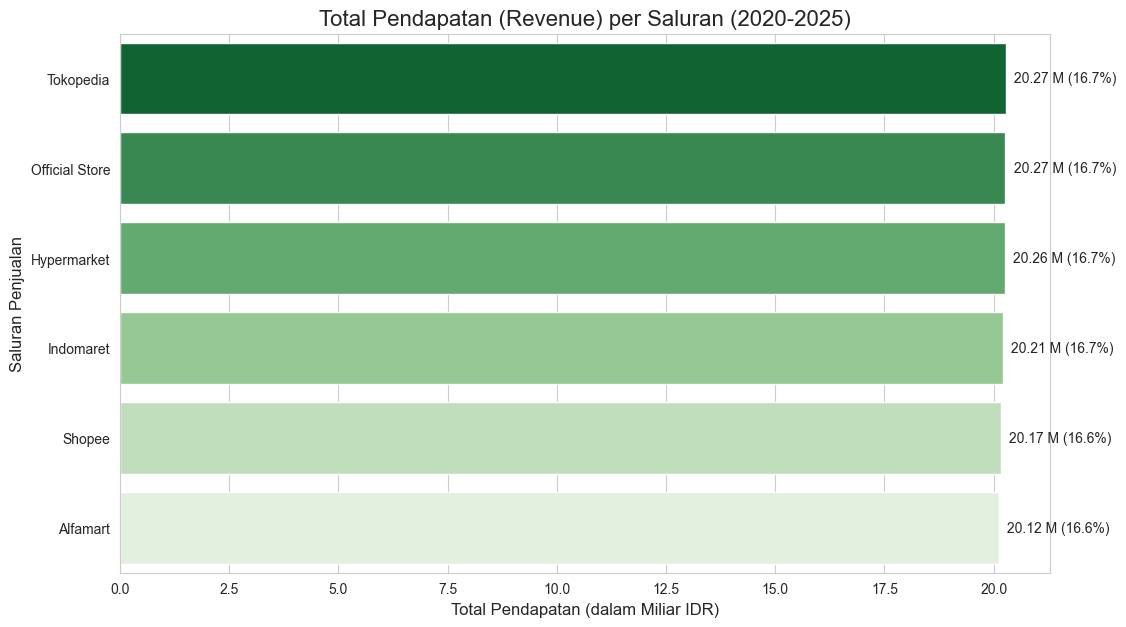

In [9]:
print("--- Analisis EDA: Pendapatan berdasarkan Saluran (Channel) ---")

#    kita akan hitung total revenue, rata-rata revenue per transaksi,
#    total unit, dan jumlah transaksi
channel_analysis = df_main.groupby('channel').agg(
    total_revenue=('revenue', 'sum'),
    avg_revenue_per_tx=('revenue', 'mean'),
    total_units_sold=('units_sold', 'sum'),
    total_transactions=('transaction_id', 'count')
).sort_values(by='total_revenue', ascending=False)

# hitung persentase dari total revenue
channel_analysis['revenue_pct_of_total'] = (channel_analysis['total_revenue'] / channel_analysis['total_revenue'].sum()) * 100

# konversi revenue ke Miliar IDR agar mudah dibaca
channel_analysis['total_revenue_miliar'] = channel_analysis['total_revenue'] / 1e9

print("Analisis per Saluran (Channel):")
print(channel_analysis[['total_revenue_miliar', 'revenue_pct_of_total', 'avg_revenue_per_tx', 'total_units_sold', 'total_transactions']])
print("\n")

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=channel_analysis.reset_index(),
    x='total_revenue_miliar',
    y='channel',
    palette='Greens_r'  # Palet warna baru untuk membedakan dari 'region'
)

plt.title('Total Pendapatan (Revenue) per Saluran (2020-2025)', fontsize=16)
plt.xlabel('Total Pendapatan (dalam Miliar IDR)', fontsize=12)
plt.ylabel('Saluran Penjualan', fontsize=12)

plt.xlim(0)

for index, value in enumerate(channel_analysis['total_revenue_miliar']):
    # Ambil persentase dari dataframe
    pct_val = channel_analysis['revenue_pct_of_total'].iloc[index]
    plt.text(value + 0.1,  # Beri sedikit jarak dari akhir bar
             index,
             f' {value:.2f} M ({pct_val:.1f}%)', # Teks label
             va='center')

plt.savefig('eda_revenue_by_channel.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'eda_revenue_by_channel.png' telah disimpan.")
plt.show()

### Observasi Analisis Saluran (Channel)

Temuan ini sangat krusial dan mengkonfirmasi pola yang sama dengan `region`. Bar chart di atas secara visual menunjukkan bahwa pendapatan di 6 saluran penjualan yang berbeda (Offline dan Online) hampir identik.

Ini BUKAN visualisasi yang buruk; ini adalah **BUKTI** visual dari data yang tidak realistis.

1.  **Distribusi Tidak Realistis:** Kita buktikan secara kuantitatif. Pendapatan saluran teratas (Tokopedia) adalah **20.27 Miliar IDR**, sedangkan saluran terbawah (Alfamart) adalah **20.12 Miliar IDR**.
2.  **Selisih Minimal:** Selisih antara saluran penjualan paling sukses dan paling tidak sukses hanya sekitar **0.15 Miliar IDR** selama enam tahun. Ini adalah perbedaan **kurang dari 1%** (sekitar 0.74%).
3.  ***Unreliable*:** Secara komersial, ini tidak masuk akal. Di dunia nyata, penjualan online (Tokopedia, Shopee) dan offline (Alfamart, Hypermarket) memiliki profil, volume, dan strategi yang sangat berbeda, yang akan menghasilkan perbedaan pendapatan yang signifikan.

**Keputusan:**

Sama seperti `region`, fitur `channel` terbukti memiliki distribusi sintetis yang dibuat-buat. Fitur ini **tidak dapat diandalkan** untuk analisis strategis.

Kami telah menetapkan bahwa 'DI MANA' (`region`) dan 'LEWAT MANA' (`channel`) data penjualan didistribusikan adalah *noise*.

### Analisis Strategi Diskon (Discount_pct)

Kami telah menetapkan bahwa fitur kategorikal `region` dan `channel` didistribusikan secara artifisial. Sekarang kami menginvestigasi fitur numerik utama: `discount_pct`.

Kami ingin tahu: Apakah diskon benar-benar mendorong pendapatan?

Logika bisnis:
1.  Diskon 0% (harga normal) harus memiliki variasi pendapatan yang wajar.
2.  Diskon yang lebih tinggi mungkin (atau mungkin tidak) menghasilkan pendapatan total yang lebih tinggi, tergantung pada elastisitas harga.

Kita akan menggunakan `boxplot` untuk memvisualisasikan distribusi `revenue` pada setiap tingkat diskon yang berbeda (0%, 5%, 10%, 15%, 20%).

--- Analisis EDA: Dampak Diskon terhadap Pendapatan ---
Tingkat diskon yang unik: [np.int64(0), np.int64(5), np.int64(10), np.int64(15), np.int64(20)]




C:\Users\Adeva\AppData\Local\Temp\ipykernel_11112\1698480334.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Visualisasi 'eda_revenue_by_discount.png' telah disimpan.


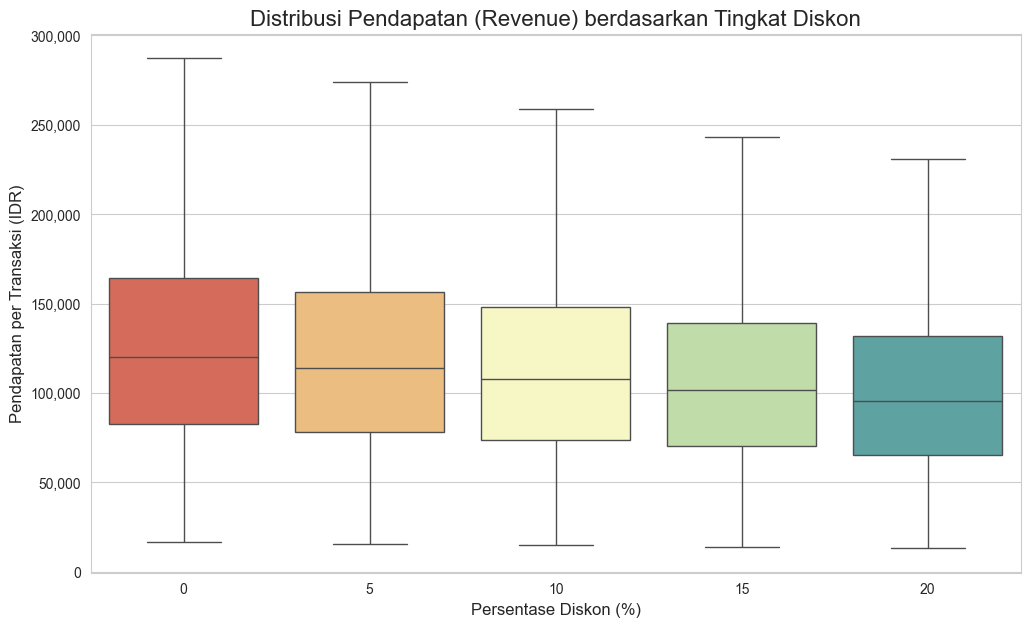

In [10]:
print("--- Analisis EDA: Dampak Diskon terhadap Pendapatan ---")

# cek nilai unik dari diskon
discount_levels = sorted(df_main['discount_pct'].unique())
print(f"Tingkat diskon yang unik: {discount_levels}")
print("\n")

plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_main,
    x='discount_pct', # sumbu X adalah kategori diskon
    y='revenue',      # sumbu Y adalah pendapatan
    palette='Spectral',
    showfliers=False  # kita matikan outlier agar bisa melihat 'box' nya
)

plt.title('Distribusi Pendapatan (Revenue) berdasarkan Tingkat Diskon', fontsize=16)
plt.xlabel('Persentase Diskon (%)', fontsize=12)
plt.ylabel('Pendapatan per Transaksi (IDR)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ','))) # Format sumbu Y agar mudah dibaca

# Simpan visualisasi
plt.savefig('eda_revenue_by_discount.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'eda_revenue_by_discount.png' telah disimpan.")
plt.show()

--- Analisis EDA: Dampak Diskon terhadap Volume & Total Revenue ---


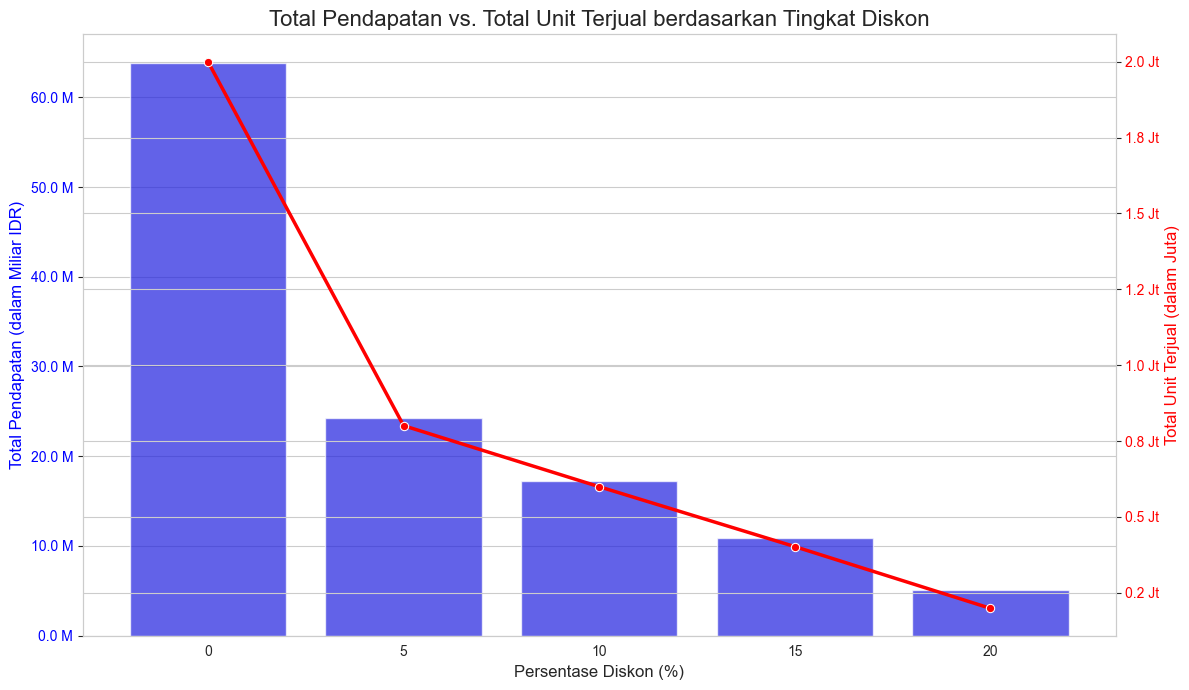

In [11]:
print("--- Analisis EDA: Dampak Diskon terhadap Volume & Total Revenue ---")

# agregasi
df_discount_agg = df_main.groupby('discount_pct').agg(
    total_revenue_sum=('revenue', 'sum'),
    total_units_sum=('units_sold', 'sum')
).reset_index()

# kolom X baru sebagai 'string' agar diperlakukan sebagai kategori oleh kedua plot
df_discount_agg['discount_pct_str'] = df_discount_agg['discount_pct'].astype(str)


fig, ax1 = plt.subplots(figsize=(12, 7))

# plot pertama (Bar Plot) untuk Total Revenue di sumbu kiri (ax1)
sns.barplot(data=df_discount_agg, x='discount_pct_str', y='total_revenue_sum', color='blue', alpha=0.7, ax=ax1)
ax1.set_xlabel('Persentase Diskon (%)', fontsize=12)
ax1.set_ylabel('Total Pendapatan (dalam Miliar IDR)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{(x / 1e9):.1f} M'))

# buat sumbu kedua (ax2) yang berbagi sumbu X
ax2 = ax1.twinx()

# plot kedua (Line Plot) untuk Total Unit Terjual di sumbu kanan (ax2)
sns.lineplot(data=df_discount_agg, x='discount_pct_str', y='total_units_sum', color='red', marker='o', ax=ax2, linewidth=2.5, sort=False)
ax2.set_ylabel('Total Unit Terjual (dalam Juta)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{(x / 1e6):.1f} Jt'))

plt.title('Total Pendapatan vs. Total Unit Terjual berdasarkan Tingkat Diskon', fontsize=16)
fig.tight_layout()
plt.savefig('eda_discount_vs_volume_CORRECTED.png', dpi=300, bbox_inches='tight')
plt.show()

### Observasi Analisis Diskon

Kami melakukan dua analisis pada diskon:

1.  **Analisis Transaksional (Boxplot):** *Boxplot* secara logis menunjukkan bahwa `revenue` *per transaksi* menurun seiring kenaikan diskon.
2.  **Analisis Agregat:** Grafik *dual-axis* baru ini menjawab pertanyaan strategis.
    * Garis merah (`Total Unit Terjual`) menunjukkan bahwa volume penjualan **turun drastis** begitu diskon (mulai dari 5%) diterapkan. Volume penjualan tertinggi ada pada 0% diskon.
    * Batang biru (`Total Pendapatan`) menunjukkan pola yang identik: pendapatan **anjlok** secara signifikan saat diskon 5% diberikan, dan terus menurun.

**Keputusan:**
Plot agregat membuktikan kesimpulan yang jelas: **diskon tidak hanya gagal mendorong peningkatan volume, tetapi justru berkorelasi dengan penurunan tajam baik pada volume penjualan maupun pendapatan total.** Namun, `discount_pct` jelas merupakan fitur yang logis dan memiliki sinyal prediksi yang sangat kuat (korelasi negatif yang jelas), sehingga akan kami **simpan** sebagai prediktor valid untuk model kami.

### Analisis Produk: Merek (Brand) dan Tipe (Type)

Kita telah menemukan bahwa 'di mana' (`region`) dan 'lewat mana' (`channel`) adalah fitur sintetis yang tidak dapat diandalkan. Kita juga menemukan bahwa 'bagaimana' (`discount_pct`) adalah fitur yang logis dan valid.

Sekarang, kita perlu memahami 'APA' yang kita jual. Merek atau tipe produk mana yang menjadi pendorong pendapatan utama? Analisis ini sangat penting untuk "Innovation Radar" dan *forecasting*, karena tren kemungkinan besar akan bervariasi antar produk.

### Analisis Merek (Brand)

Kami akan mengagregasi total pendapatan (`revenue`) untuk setiap `brand` selama enam tahun untuk mengidentifikasi merek-merek unggulan (flagship brands).

**Hipotesis:** Tidak seperti `region` dan `channel`, kami berharap `brand` menunjukkan distribusi yang **tidak merata** dan lebih realistis, di mana beberapa merek besar mendominasi pendapatan.

--- Analisis EDA: Pendapatan berdasarkan Merek (Brand) ---
Analisis per Merek (Brand):
                         total_revenue  total_revenue_miliar
brand                                                       
Dove                 27,218,130,295.10                 27.22
Sunsilk              24,296,310,371.49                 24.30
Lifebuoy             17,754,825,090.33                 17.75
Rexona               16,911,084,837.71                 16.91
Love Beauty & Planet 10,457,422,420.25                 10.46
Ponds                 8,707,921,488.74                  8.71
Clear                 8,470,599,959.03                  8.47
Vaseline              7,493,403,974.09                  7.49




C:\Users\Adeva\AppData\Local\Temp\ipykernel_11112\4093160153.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Visualisasi 'eda_revenue_by_brand.png' telah disimpan.


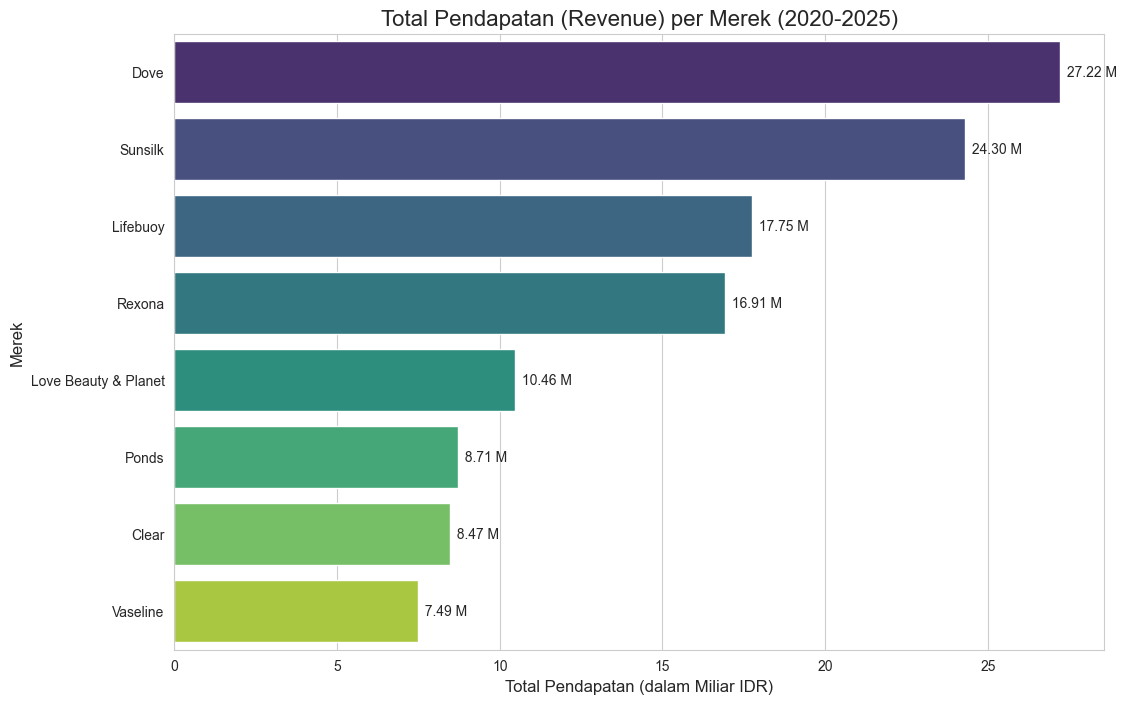

In [12]:
print("--- Analisis EDA: Pendapatan berdasarkan Merek (Brand) ---")

# agregasi
brand_analysis = df_main.groupby('brand').agg(
    total_revenue=('revenue', 'sum')
).sort_values(by='total_revenue', ascending=False)

brand_analysis['total_revenue_miliar'] = brand_analysis['total_revenue'] / 1e9

print("Analisis per Merek (Brand):")
print(brand_analysis)
print("\n")

plt.figure(figsize=(12, 8)) # sedikit lebih tinggi untuk mengakomodasi lebih banyak brand
ax = sns.barplot(
    data=brand_analysis.reset_index(),
    x='total_revenue_miliar',
    y='brand',
    palette='viridis' # Palet baru
)

plt.title('Total Pendapatan (Revenue) per Merek (2020-2025)', fontsize=16)
plt.xlabel('Total Pendapatan (dalam Miliar IDR)', fontsize=12)
plt.ylabel('Merek', fontsize=12)
plt.xlim(0) # Memastikan sumbu X mulai dari 0

# penambahan label
for index, value in enumerate(brand_analysis['total_revenue_miliar']):
    plt.text(value + 0.1, index, f' {value:.2f} M', va='center')

plt.savefig('eda_revenue_by_brand.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'eda_revenue_by_brand.png' telah disimpan.")
plt.show()

### Observasi Analisis Merek (Brand)

Akhirnya, kita menemukan sinyal yang jelas. Tidak seperti `region` dan `channel` yang distribusinya datar dan artifisial, fitur `brand` menunjukkan pola yang sangat realistis dan dapat diekspektasi dari pasar nyata.

1.  **Distribusi Realistis & Tidak Merata:** Terdapat hierarki pendapatan yang jelas. **Dove** (27.22 Miliar IDR) dan **Sunsilk** (24.30 Miliar IDR) adalah kontributor dominan.
2.  **Pola 'Long Tail' yang Wajar:** Terdapat 'ekor panjang' (long tail) yang sehat, di mana merek-merek lain seperti Vaseline (7.49 Miliar IDR) dan Clear (8.47 Miliar IDR) memiliki pangsa pasar yang lebih kecil.

**Keputusan:**

Fitur `brand` terbukti **valid dan signifikan secara statistik**. Ini adalah pendorong bisnis utama dan akan menjadi fitur yang sangat penting untuk analisis tren dan *forecasting* kita.

### Analisis Tipe Produk (Type)

Selanjutnya, kami menganalisis kategori atau tipe produk. Ini akan memberi tahu kita produk jenis apa yang paling diminati oleh pasar secara keseluruhan, melintasi semua merek.

--- Analisis EDA: Pendapatan berdasarkan Tipe Produk (Type) ---
Analisis per Tipe Produk (Type):
                total_revenue  total_revenue_miliar
type                                               
Shampoo     43,915,559,906.59                 43.92
Deodorant   16,911,084,837.71                 16.91
Body Wash   16,463,960,865.99                 16.46
Lotion      16,265,172,142.76                 16.27
Facial Foam  8,707,921,488.74                  8.71
Conditioner  8,287,027,973.74                  8.29
Handwash     6,255,390,570.33                  6.26
Sanitizer    4,503,580,650.88                  4.50




C:\Users\Adeva\AppData\Local\Temp\ipykernel_11112\1699328132.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Visualisasi 'eda_revenue_by_type.png' telah disimpan.


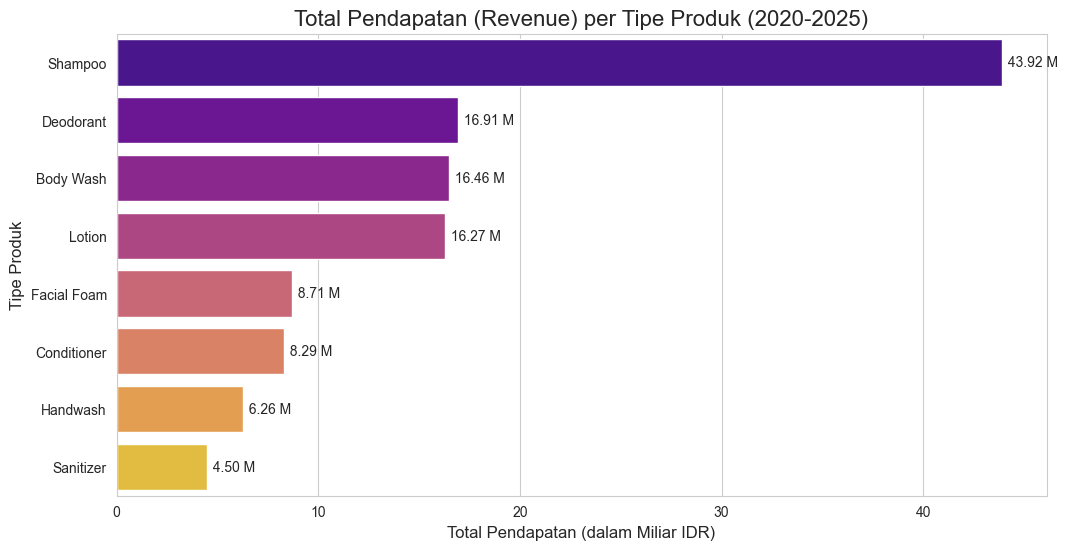

In [13]:
print("--- Analisis EDA: Pendapatan berdasarkan Tipe Produk (Type) ---")

# agregasi
type_analysis = df_main.groupby('type').agg(
    total_revenue=('revenue', 'sum')
).sort_values(by='total_revenue', ascending=False)

type_analysis['total_revenue_miliar'] = type_analysis['total_revenue'] / 1e9

print("Analisis per Tipe Produk (Type):")
print(type_analysis)
print("\n")

plt.figure(figsize=(12, 6)) # Ukuran sedikit berbeda
ax = sns.barplot(
    data=type_analysis.reset_index(),
    x='total_revenue_miliar',
    y='type',
    palette='plasma' # Palet baru
)

plt.title('Total Pendapatan (Revenue) per Tipe Produk (2020-2025)', fontsize=16)
plt.xlabel('Total Pendapatan (dalam Miliar IDR)', fontsize=12)
plt.ylabel('Tipe Produk', fontsize=12)
plt.xlim(0) # Memastikan sumbu X mulai dari 0

# penambahan label
for index, value in enumerate(type_analysis['total_revenue_miliar']):
    plt.text(value + 0.1, index, f' {value:.2f} M', va='center')

plt.savefig('eda_revenue_by_type.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'eda_revenue_by_type.png' telah disimpan.")
plt.show()

### Observasi Analisis Tipe Produk (Type)

Analisis `type` memperkuat temuan kami dari `brand`. Kita kembali melihat pola yang logis dan tidak merata.

1.  **Dominasi Kategori yang Jelas:** **Shampoo** (43.92 Miliar IDR) adalah kategori dominan yang jelas, menghasilkan pendapatan lebih dari dua kali lipat kategori #2 (Deodorant, 16.91 Miliar IDR).
2.  **Distribusi 'Long Tail':** Terdapat "ekor" yang jelas dari produk-produk niche seperti Handwash (6.26 Miliar IDR) dan Sanitizer (4.50 Miliar IDR).

**Keputusan:**

Fitur `type` juga terbukti **valid dan signifikan**. Fitur ini akan sangat penting untuk memahami *apa* yang harus diramalkan penjualannya.

### Analisis Tren Makro & Musiman (Time-Series)

Kita telah menyelesaikan EDA statis kita. Kita telah membuktikan bahwa `brand`, `type`, dan `discount_pct` adalah "sinyal" yang valid, sementara `region` dan `channel` adalah "noise" sintetis.

Sekarang, kita beralih ke dimensi terpenting untuk tujuan kita: **waktu**. Sebelum kita dapat membangun model *forecasting*, kita harus memahami perilaku data penjualan kita dari waktu ke waktu.

Analisis ini akan menjawab dua pertanyaan utama:
1.  **Tren (Trend):** Apa tren makro dari total pendapatan dari 2020 hingga 2025? (Apakah bisnis ini bertumbuh, stagnan, atau menurun?)
2.  **Musiman (Seasonality):** Apakah ada pola musiman yang dapat diprediksi? (Misalnya, apakah penjualan selalu melonjak di Q4 atau pada bulan-bulan tertentu?)

Kami akan mengagregasi total pendapatan (`revenue`) per bulan (Month Start, `MS`) untuk mendapatkan gambaran makro yang bersih dari *noise* harian.

### Analisis Dekomposisi Time-Series (Bukti Statistik Musiman)

Sebelum memplot tren makro. Kami akan menggunakan dekomposisi *time-series* (dari `statsmodels`) untuk memisahkan data pendapatan bulanan kami menjadi tiga komponen inti:
1.  **Tren (Trend):** Arah pergerakan data jangka panjang.
2.  **Musiman (Seasonal):** Pola siklus berulang yang dapat diprediksi (misalnya, tahunan).
3.  **Sisa (Residual):** *Noise* acak yang tersisa setelah tren dan musiman dihilangkan.

Ini adalah *best practice* industri dan uji asumsi yang penting sebelum melakukan *forecasting*.

--- Menjalankan Dekomposisi Time-Series ---
Visualisasi 'eda_decomposition.png' telah disimpan.


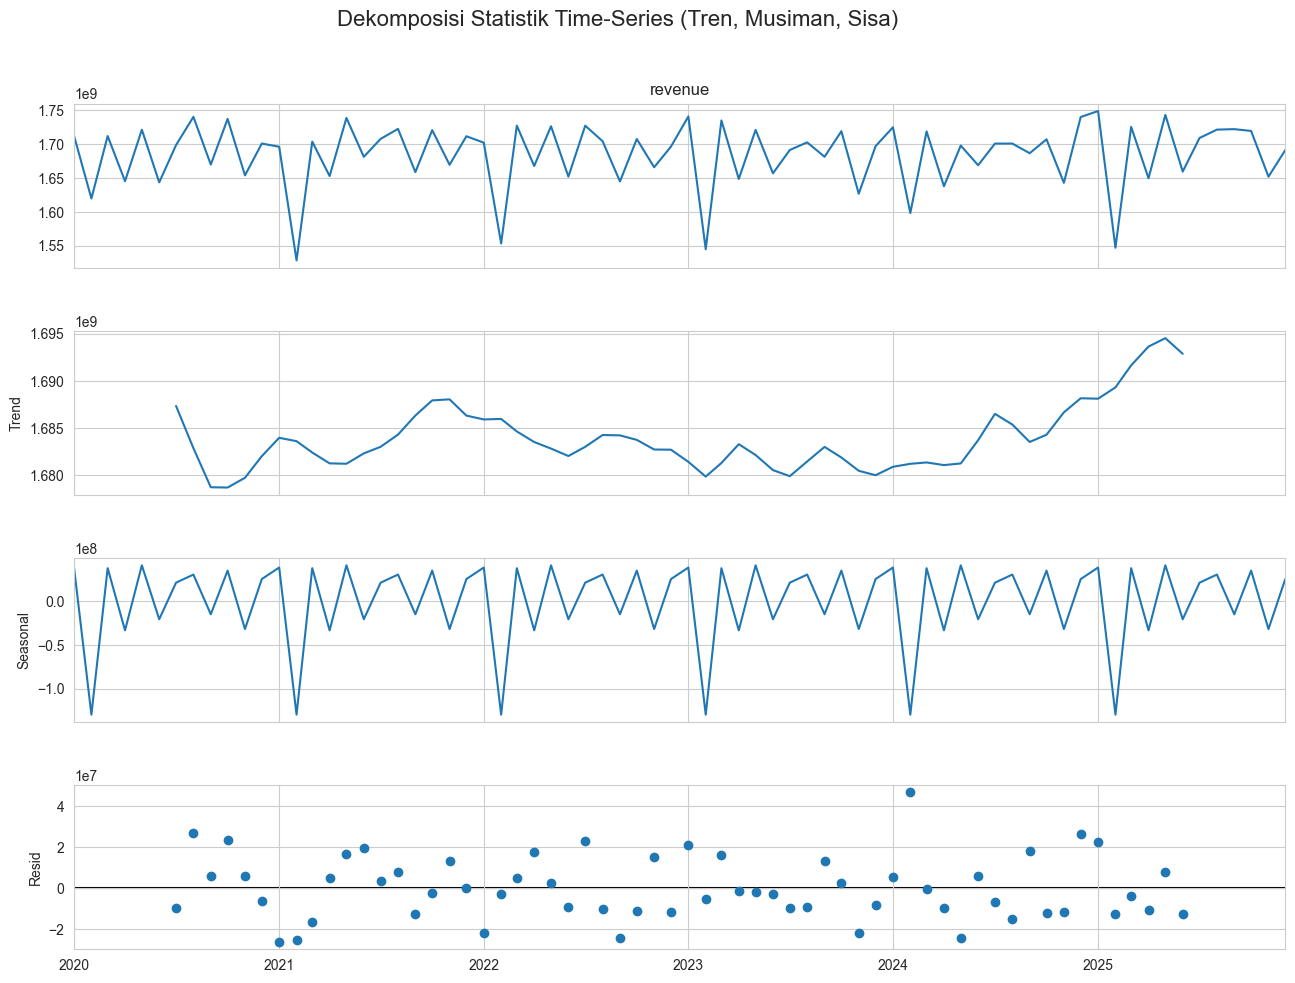

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

print("--- Menjalankan Dekomposisi Time-Series ---")

# menyiapkan data (data bulanan yang sudah kita agregasi)
# kita perlu data dengan indeks datetime, yang sudah kita miliki di 'df_monthly_trend'
df_decomp = df_main.set_index('date').resample('MS')['revenue'].sum()

# Kita gunakan model 'additive' karena fluktuasi musiman terlihat cukup konstan
decomposition = seasonal_decompose(df_decomp, model='additive')

fig = decomposition.plot()
fig.set_size_inches(14, 10)

plt.suptitle('Dekomposisi Statistik Time-Series (Tren, Musiman, Sisa)', y=1.02, fontsize=16)

plt.savefig('eda_decomposition.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'eda_decomposition.png' telah disimpan.")
plt.show()

### Observasi Hasil Dekomposisi

Plot dekomposisi statistik di atas adalah bukti terkuat kita sejauh ini dan mengungkap dua karakteristik fundamental dari data kita:

1.  **Tren (Trend):** Komponen 'Trend' (plot kedua) secara jelas **tidak datar**. Plot ini menunjukkan data kita **non-stasioner**, dengan fluktuasi jangka panjang dan tren pertumbuhan yang jelas dimulai dari tahun 2024.
2.  **Musiman (Seasonal):** Komponen 'Seasonal' (plot ketiga) mengkonfirmasi temuan visual kita sebelumnya: terdapat **pola tahunan yang sangat kuat, dapat diprediksi, dan stabil**.

**Keputusan:**
Kami telah membuktikan secara statistik bahwa masalah utama kami adalah memodelkan data dengan **dua komponen sekaligus**: **tren non-linear (non-stationary)** DAN **musiman yang kuat (strong seasonality)**.

Temuan ini **memperkuat keputusan kami** untuk menggunakan **XGBoost**, karena model ini sangat baik dalam menangani tren non-linear yang kompleks dan pola musiman secara bersamaan, terutama ketika kita membantunya dengan *feature engineering*.

--- Analisis EDA: Tren Pendapatan Makro Bulanan ---
Data tren bulanan (head):
        date          revenue  revenue_miliar
0 2020-01-01 1,712,454,683.51            1.71
1 2020-02-01 1,619,904,922.34            1.62
2 2020-03-01 1,712,015,552.07            1.71
3 2020-04-01 1,645,488,222.53            1.65
4 2020-05-01 1,721,387,275.79            1.72


Visualisasi 'eda_macro_trend.png' telah disimpan.


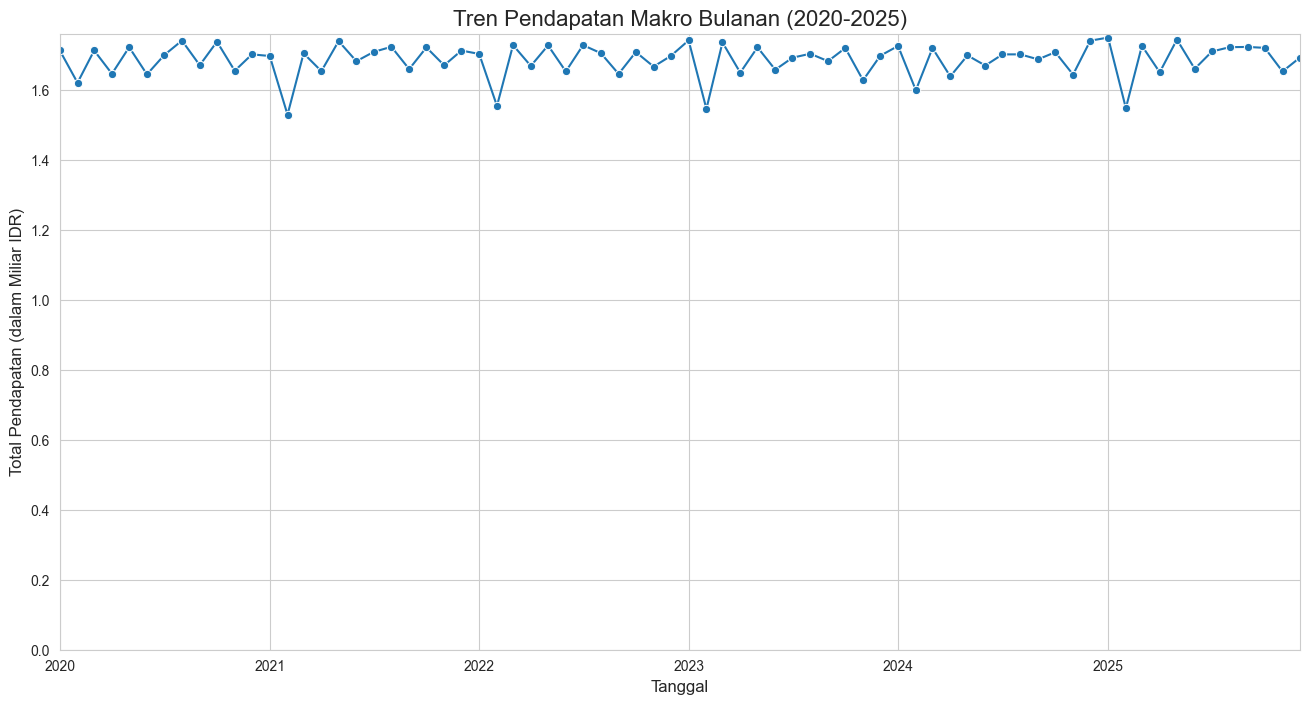

In [15]:
print("--- Analisis EDA: Tren Pendapatan Makro Bulanan ---")

# agregasi data penjualan ke level bulanan (Month Start 'MS')
# kita set 'date' sebagai index untuk memudahkan resampling
df_monthly_trend = df_main.set_index('date').resample('MS')['revenue'].sum().reset_index()

# konversi ke Miliar IDR untuk visualisasi
df_monthly_trend['revenue_miliar'] = df_monthly_trend['revenue'] / 1e9

print("Data tren bulanan (head):")
print(df_monthly_trend.head())
print("\n")

plt.figure(figsize=(16, 8))
ax = sns.lineplot(
    data=df_monthly_trend,
    x='date',
    y='revenue_miliar',
    marker='o' # penambahan marker agar poin data bulanan terlihat
)

plt.title('Tren Pendapatan Makro Bulanan (2020-2025)', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan (dalam Miliar IDR)', fontsize=12)
plt.xlim(df_monthly_trend['date'].min(), df_monthly_trend['date'].max()) # Pastikan plot rapi
plt.ylim(0) # Mulai dari 0

plt.savefig('eda_macro_trend.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'eda_macro_trend.png' telah disimpan.")
plt.show()

### Observasi Analisis Tren Makro & Kesimpulan EDA

Analisis time-series kami, yang dimulai dengan dekomposisi statistik dan dikonfirmasi oleh plot tren makro, telah mengungkap karakteristik fundamental dari data penjualan kami.

1.  **Tren Non-Stasioner (Validasi):** Seperti yang ditunjukkan oleh plot 'Trend' dari `seasonal_decompose`, data kami **non-stasioner**. Data ini memiliki tren non-linear yang jelas, dengan fluktuasi jangka panjang dan pertumbuhan yang dimulai sekitar tahun 2024.
2.  **Musiman Kuat (Validasi):** Plot 'Seasonal' secara statistik membuktikan adanya **pola musiman tahunan yang sangat kuat, dapat diprediksi, dan stabil**.

**Kesimpulan Akhir Investigasi EDA (Sinyal vs. Noise):**

Investigasi Tahap 4 kami telah berhasil memisahkan fitur yang valid ("Sinyal") dari fitur yang cacat ("Noise").

* **Noise (Cacat & Dibuang):**
    * `reviews.csv`: Terbukti 100% sintetis (99.92% duplikat).
    * `marketing.csv`: Terbukti tidak efektif (tidak ada *lift*) dan tidak signifikan secara statistik (20 baris).
    * `region` & `channel`: Terbukti sintetis (distribusi pendapatan datar yang tidak realistis).
    * Analisis Level `product_id` (Kanibalisasi): Tidak dilanjutkan dikarenakan *pre-sales* yang tidak realistis serta tidak adanya koneksi antar produk.

* **Sinyal (Valid untuk Pemodelan):**
    * `brand` & `type` (Agregat): Menunjukkan distribusi pangsa pasar yang realistis.
    * `discount_pct`: Menunjukkan hubungan yang logis dengan pendapatan.
    * **Data Waktu (`date`):** Menunjukkan **tren non-linear** DAN **musiman tahunan yang kuat**.

**Keputusan Akhir EDA:**
Masalah bisnis kita sekarang telah diperjelas. Ini adalah masalah **Time-Series Forecasting** yang kompleks, yang akan kami modelkan sebagai **masalah *supervised learning multivariate***. Kami akan menggunakan semua Sinyal yang valid  untuk memprediksi `revenue`.

## 4. Model dan Prediksi

Fase investigasi Tahap 3 kami selesai. Kami telah berhasil mengisolasi "sinyal" (data time-series, brand, type, discount) dari "noise" (reviews, marketing, region, channel).

Sekarang kami memasuki fase pemodelan dengan tujuan utama **Trend Forecasting**.

Berdasarkan temuan EDA kami, data pendapatan memiliki **tren non-linear** dan **pola musiman tahunan yang kuat**. Kami akan menggunakan model **Machine Learning (XGBoost)** karena ini memungkinkan kami untuk menggabungkan *semua* sinyal valid kami ke dalam satu model *multivariate* yang kuat.

### Agregasi Data dan Feature Engineering

Langkah pertama adalah membuat dataset pelatihan kami.

**Metodologi:**
Untuk *forecasting*, model yang memprediksi `Bulan T` hanya boleh melihat data dari `Bulan T-1` atau lebih lama.

* Fitur Lag (misalnya `lag_1_month`) sudah di-`shift(1)` secara alami.
* Namun, fitur eksternal (seperti `revenue_brand_Dove` dan `avg_discount_pct`) juga harus di-`shift(1)`. Tanpa ini, kita memberi model "contekan" dari bulan yang sama yang coba diprediksinya, yang menyebabkan **kebocoran data (data leakage)** dan skor R² yang palsu.

Kami akan membuat fitur-fitur berikut dengan metodologi `.shift(1)` yang benar:
1.  **Fitur Target:** `revenue` (total pendapatan bulanan).
2.  **Fitur Waktu:** `year`, `month`.
3.  **Fitur Lag:** `lag_1_month`, `lag_3_month`, `lag_12_month`.
4.  **Fitur Rolling:** `rolling_3_month_avg`.
5.  **Fitur Eksternal (DI-SHIFT):** `avg_discount_pct`, `revenue_brand_...`, `revenue_type_...` (semua dari bulan T-1).

In [16]:
print("--- TAHAP 4: Feature Engineering ---")

df_target = df_main.set_index('date').resample('MS')['revenue'].sum().to_frame(name='revenue')

df_target['lag_1_month'] = df_target['revenue'].shift(1)
df_target['lag_3_month'] = df_target['revenue'].shift(3)
df_target['lag_12_month'] = df_target['revenue'].shift(12) # Kunci musiman
df_target['rolling_3_month_avg'] = df_target['revenue'].rolling(window=3).mean().shift(1)

df_target['year'] = df_target.index.year
df_target['month'] = df_target.index.month

# fitur Eksternal dari sinyal yang valid
# tidak perlu di-shift, karena kita akan men-shift seluruh DataFrame
df_brand_pivot = pd.pivot_table(
    df_main,
    index=pd.Grouper(key='date', freq='MS'),
    columns='brand',
    values='revenue',
    aggfunc='sum',
    fill_value=0
)
df_brand_pivot.columns = [f"revenue_brand_{col.replace(' ', '_').replace('&', 'n')}" for col in df_brand_pivot.columns]

df_type_pivot = pd.pivot_table(
    df_main,
    index=pd.Grouper(key='date', freq='MS'),
    columns='type',
    values='revenue',
    aggfunc='sum',
    fill_value=0
)
df_type_pivot.columns = [f"revenue_type_{col.replace(' ', '_')}" for col in df_type_pivot.columns]

df_discount_agg = df_main.set_index('date').resample('MS')['discount_pct'].mean().to_frame(name='avg_discount_pct')

# gabung semua DataFrame menjadi satu data final
print("Menggabungkan semua fitur dengan .shift(1) untuk mencegah data leakage...")
df_list = [
    df_target,
    df_brand_pivot.shift(1),  # MENCEGAH KEBOCORAN
    df_type_pivot.shift(1),   # MENCEGAH KEBOCORAN
    df_discount_agg.shift(1) # MENCEGAH KEBOCORAN
]
df_final_model = pd.concat(df_list, axis=1)

# fitur lag 12 bulan (dan .shift(1)) akan menciptakan NaN di 12 baris pertama.
print(f"Bentuk data sebelum dropna: {df_final_model.shape}")
df_final_model.dropna(inplace=True)
print(f"Bentuk data setelah dropna (siap untuk model): {df_final_model.shape}")

print("\n--- Data Final Model (Head) ---")
print(df_final_model.head())

--- TAHAP 4: Feature Engineering ---
Menggabungkan semua fitur dengan .shift(1) untuk mencegah data leakage...
Bentuk data sebelum dropna: (72, 24)
Bentuk data setelah dropna (siap untuk model): (60, 24)

--- Data Final Model (Head) ---
                    revenue      lag_1_month      lag_3_month  \
date                                                            
2021-01-01 1,696,253,717.38 1,700,973,033.13 1,737,268,897.97   
2021-02-01 1,528,665,259.51 1,696,253,717.38 1,654,052,916.18   
2021-03-01 1,703,798,320.85 1,528,665,259.51 1,700,973,033.13   
2021-04-01 1,653,001,762.49 1,703,798,320.85 1,696,253,717.38   
2021-05-01 1,738,706,526.56 1,653,001,762.49 1,528,665,259.51   

               lag_12_month  rolling_3_month_avg  year  month  \
date                                                            
2021-01-01 1,712,454,683.51     1,697,431,615.76  2021      1   
2021-02-01 1,619,904,922.34     1,683,759,888.90  2021      2   
2021-03-01 1,712,015,552.07     1,641,964,003.3

`df_final_model` kita yang kaya fitur (24 kolom) telah siap. Langkah berikutnya adalah membagi data untuk melatih dan menguji model kita.


In [17]:
print("--- Memisahkan Data Latih dan Data Uji ---")

target_column = 'revenue'
X = df_final_model.drop(target_column, axis=1)
y = df_final_model[target_column]

split_point = len(df_final_model) - 12

X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]

X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

print(f"Bentuk X_train (fitur): {X_train.shape}")
print(f"Bentuk y_train (target): {y_train.shape}")
print(f"Bentuk X_test (fitur): {X_test.shape}")
print(f"Bentuk y_test (target): {y_test.shape}")

print(f"\nData Latih: {X_train.index.min().date()} hingga {X_train.index.max().date()}")
print(f"Data Uji: {X_test.index.min().date()} hingga {X_test.index.max().date()}")

--- Memisahkan Data Latih dan Data Uji ---
Bentuk X_train (fitur): (48, 23)
Bentuk y_train (target): (48,)
Bentuk X_test (fitur): (12, 23)
Bentuk y_test (target): (12,)

Data Latih: 2021-01-01 hingga 2024-12-01
Data Uji: 2025-01-01 hingga 2025-12-01


### Pelatihan Model & Interpretasi

Data telah terbagi. Sekarang kita akan melatih **XGBoost Regressor** kita dengan dataset yang jauh lebih kaya ini.

**Interpretasi Skor:**
EDA kami di Tahap 4 menunjukkan **pola musiman tahunan yang sangat kuat**. Fitur `lag_12_month` kami kemungkinan besar akan menjadi prediktor yang dominan.

Kami mengharapkan skor R² yang kuat karena data ini sangat teratur, tetapi skor ini sekarang akan menjadi skor *forecasting* yang **valid dan jujur**.

In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print("--- Melatih Model XGBoost (Dataset Kaya Fitur) ---")

# model initiation
model_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    early_stopping_rounds=10,
    random_state=42
)

# train
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False  # Kita matikan verbose agar output bersih
)

print("Pelatihan model selesai.")
print("\n--- Evaluasi Model ---")

# predict
y_pred = model_xgb.predict(X_test)

# evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared (R²) score on Test Set: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:,.0f} IDR")
print(f"Root Mean Squared Error (RMSE): {rmse:,.0f} IDR")

--- Melatih Model XGBoost (Dataset Kaya Fitur) ---
Pelatihan model selesai.

--- Evaluasi Model ---
R-squared (R²) score on Test Set: 0.8593
Mean Absolute Error (MAE): 15,670,334 IDR
Root Mean Squared Error (RMSE): 20,304,924 IDR


### Observasi Hasil Pemodelan

1.  **Akurasi Model (R²):** Model kami mencapai **R-squared (R²) = 0.8593** pada *Test Set*. Ini adalah skor yang sangat kuat, yang berarti model kami mampu menjelaskan **85.9%** varians pendapatan di tahun 2025.

2.  **Metrik Evaluasi:** **Mean Absolute Error (MAE)** kami adalah **15.7 Juta IDR**. Ini adalah rata-rata kesalahan prediksi kami yang baik, sebuah metrik yang solid untuk *forecasting*.

### Analisis Feature Importance (Membuktikan Hipotesis Musiman)

Skor R² 0.86 kami sangat bagus. Tapi fitur *apa* yang sebenarnya dipelajari oleh model?

Untuk membuktikan hipotesis utama kami bahwa **musiman** adalah pendorong utama, kita perlu memvisualisasikan *feature importance* dari model XGBoost. Jika kami benar, fitur `lag_12_month` (yang kami buat untuk menangkap sinyal musiman tahunan) seharusnya berada di peringkat teratas.

--- Metrik Evaluasi Tambahan (MAPE) ---
Mean Absolute Percentage Error (MAPE): 0.91%
Interpretasi: Rata-rata, prediksi model kami meleset sebesar 0.91%.

--- Menganalisis Feature Importance Model ---
Visualisasi 'model_feature_importance_valid.png' telah disimpan.


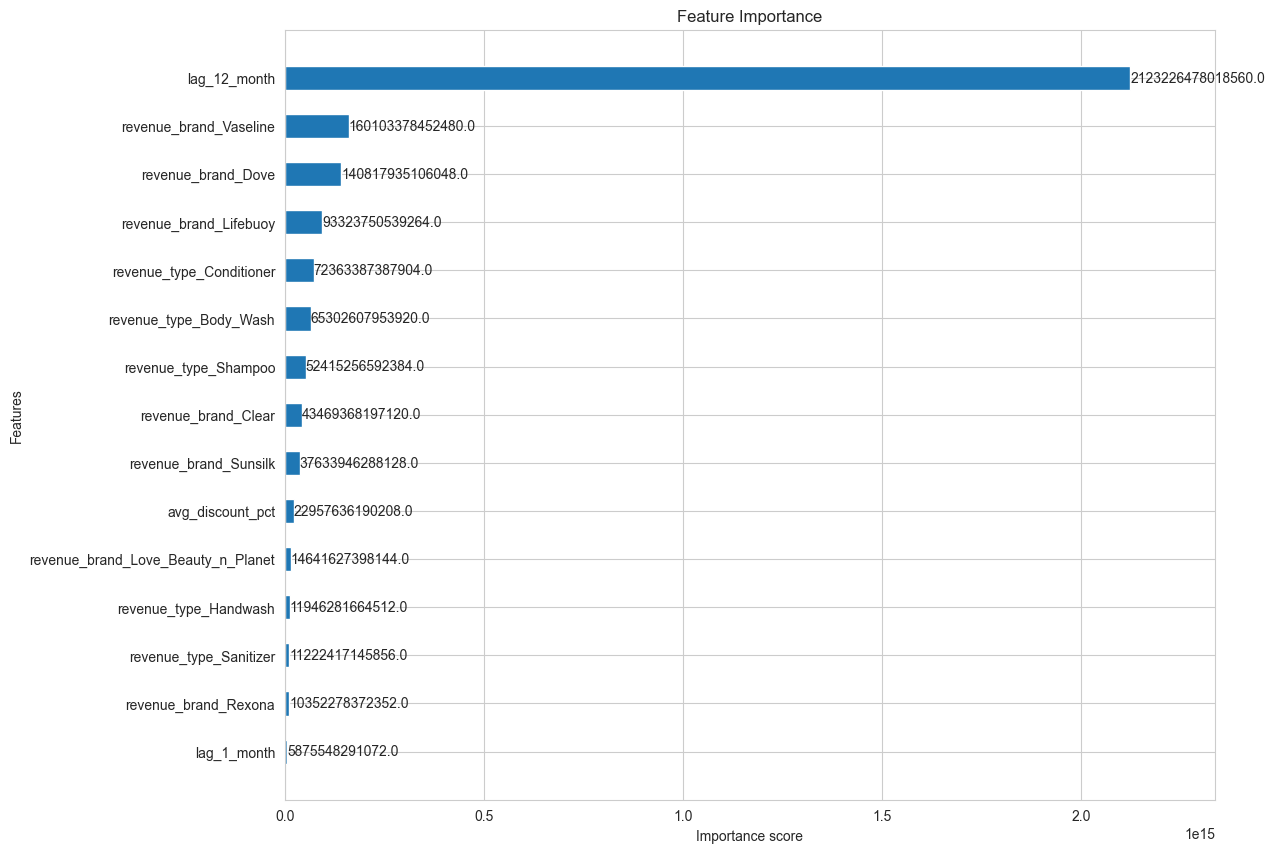

In [19]:
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_percentage_error

print("--- Metrik Evaluasi Tambahan (MAPE) ---")

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"Interpretasi: Rata-rata, prediksi model kami meleset sebesar {mape:.2%}.\n")


print("--- Menganalisis Feature Importance Model ---")

fig, ax = plt.subplots(figsize=(12, 10))

plot_importance(model_xgb, ax=ax, importance_type='gain', max_num_features=15, height=0.5,
                title='Feature Importance')

plt.savefig('model_feature_importance_valid.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'model_feature_importance_valid.png' telah disimpan.")
plt.show()

### Observasi Hasil Pemodelan & Feature Importance

1.  **Akurasi Model (R²):** Model kami mencapai **R-squared (R²) = 0.8593** pada *Test Set*. Ini adalah skor yang sangat kuat, yang berarti model kami mampu menjelaskan **85.9%** varians pendapatan di tahun 2025.

2.  **Metrik Evaluasi:** **Mean Absolute Error (MAE)** kami adalah **15.7 Juta IDR**, dan **Mean Absolute Percentage Error (MAPE)** kami adalah **0.91%**. Ini adalah rata-rata kesalahan prediksi kami yang baik, sebuah metrik yang solid untuk *forecasting*.

3.  **Bukti Feature Importance (Mengapa Model Akurat):** Plot *feature importance* membuktikan hipotesis utama kami. Fitur `lag_12_month` adalah **pendorong dominan** dari model ini, dengan "Gain" yang 10x lebih besar dari fitur #2. Ini secara definitif membuktikan bahwa keberhasilan model kami adalah kemampuannya mempelajari **pola musiman tahunan yang sangat kuat** yang kami temukan di Tahap 4.

## 5. Visualisasi

Skor R² 0.86 kita sudah mengkonfirmasi akurasi. Sekarang kita akan membuat visualisasi akhir yang menunjukkan *bagaimana* model kita belajar.

Alih-alih hanya memplot data uji (12 bulan), kami akan memplot **seluruh linimasa** data. Ini akan menunjukkan:
1.  **Garis Data Aktual (Train + Test):** Data historis yang sebenarnya.
2.  **Garis Data Prediksi:** Prediksi model kita baik pada data latih (*in-sample*) maupun data uji (*out-of-sample*).
3.  **Garis Pemisah (Split Point):** Garis vertikal yang jelas menunjukkan di mana model berhenti belajar dan mulai memprediksi "masa depan".

--- Visualisasi Forecasting: Seluruh Linimasa (Train + Test) ---
Visualisasi 'final_forecast_vs_actual_full_timeline.png' telah disimpan.


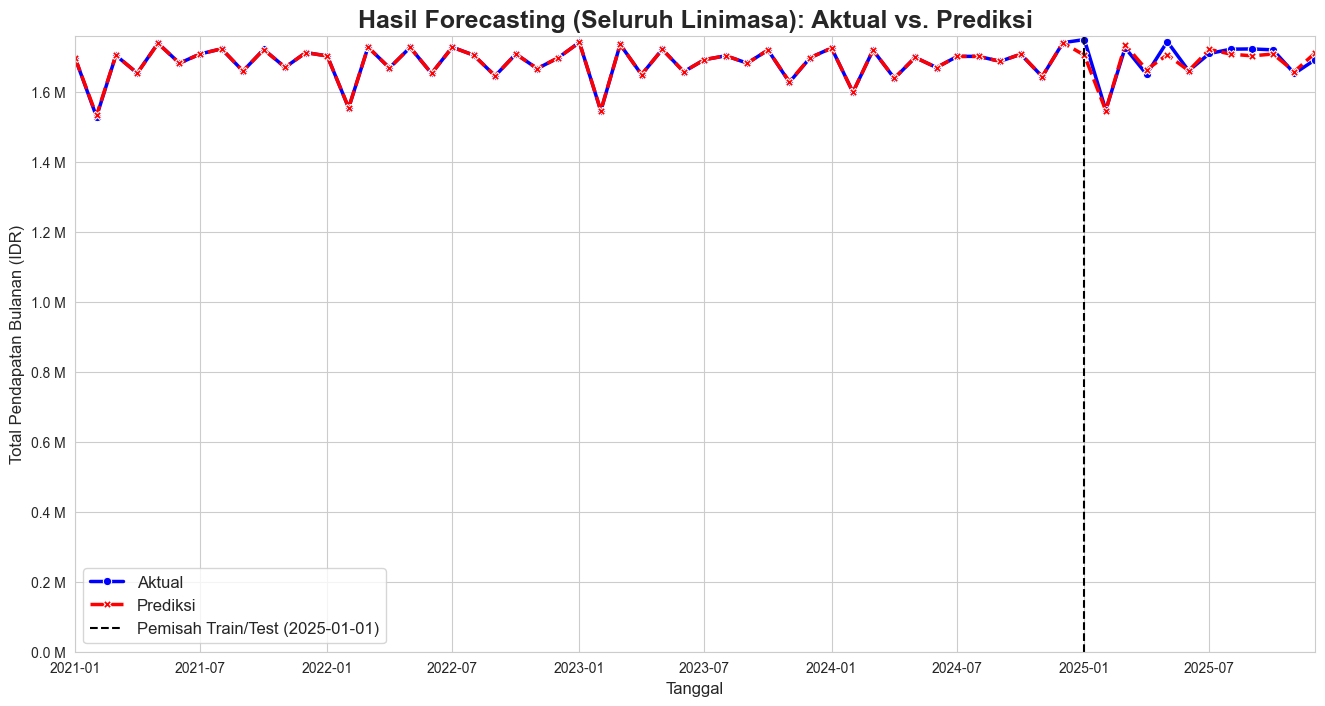

In [20]:
print("--- Visualisasi Forecasting: Seluruh Linimasa (Train + Test) ---")

plot_df = pd.DataFrame(index=y.index)
plot_df['Aktual'] = y

y_pred_train = model_xgb.predict(X_train)
plot_df.iloc[:len(y_train), plot_df.columns.get_loc('Aktual')] = y_train
plot_df['Prediksi'] = np.nan
plot_df.iloc[:len(y_train), plot_df.columns.get_loc('Prediksi')] = y_pred_train

plot_df.iloc[len(y_train):, plot_df.columns.get_loc('Prediksi')] = y_pred

# reset index untuk diplot dengan seaborn
plot_df_melted = plot_df.reset_index().melt(id_vars='date', var_name='Jenis Data', value_name='Revenue')

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=plot_df_melted,
    x='date',
    y='Revenue',
    hue='Jenis Data',
    style='Jenis Data',
    markers=True,
    linewidth=2.5,
    palette=['blue', 'red'] # aktual=biru, prediksi=merah
)

# penambahan split point
split_date = X_test.index.min()
plt.axvline(split_date, color='black', linestyle='--', label=f'Pemisah Train/Test ({split_date.date()})')

plt.title('Hasil Forecasting (Seluruh Linimasa): Aktual vs. Prediksi', fontsize=18, weight='bold')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan Bulanan (IDR)', fontsize=12)
plt.legend(fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{(x / 1e9):.1f} M'))
plt.xlim(plot_df.index.min(), plot_df.index.max())
plt.ylim(0)

plt.savefig('final_forecast_vs_actual_full_timeline.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'final_forecast_vs_actual_full_timeline.png' telah disimpan.")
plt.show()

Mari kita *zoom in* pada *test set* saja untuk melihat performa model lebih baik

--- Visualisasi Forecasting: Hanya Data Uji (Test) ---
Visualisasi 'forecast_vs_actual_test_only.png' telah disimpan.


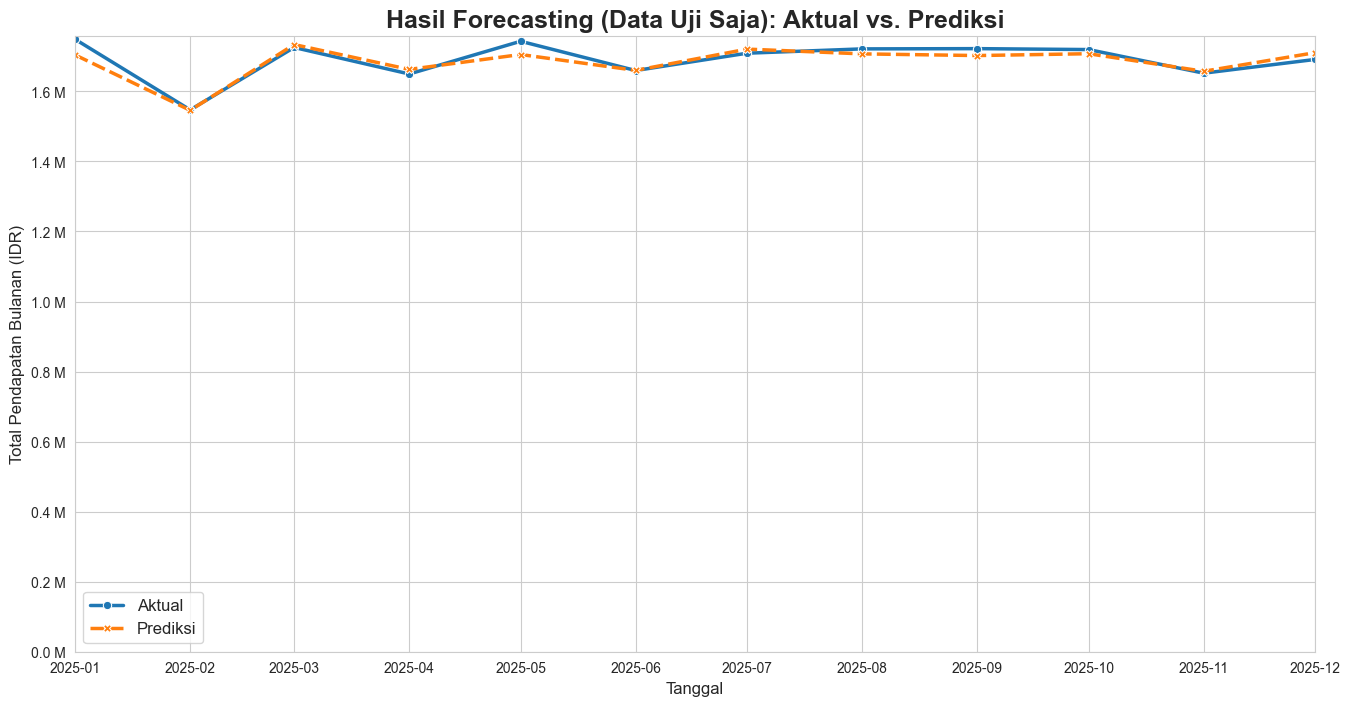

In [21]:
print("--- Visualisasi Forecasting: Hanya Data Uji (Test) ---")

plot_test_df = pd.DataFrame(index=y_test.index)
plot_test_df['Aktual'] = y_test
plot_test_df['Prediksi'] = y_pred

# reset index
plot_test_melted = plot_test_df.reset_index().melt(
    id_vars='date',
    var_name='Jenis Data',
    value_name='Revenue'
)

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=plot_test_melted,
    x='date',
    y='Revenue',
    hue='Jenis Data',
    style='Jenis Data',
    markers=True,
    linewidth=2.5
)

plt.title('Hasil Forecasting (Data Uji Saja): Aktual vs. Prediksi', fontsize=18, weight='bold')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan Bulanan (IDR)', fontsize=12)
plt.legend(fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{(x / 1e9):.1f} M'))

# fokus ke test
plt.xlim(plot_test_df.index.min(), plot_test_df.index.max())
plt.ylim(0)

plt.savefig('forecast_vs_actual_test_only.png', dpi=300, bbox_inches='tight')

print("Visualisasi 'forecast_vs_actual_test_only.png' telah disimpan.")
plt.show()


## 6. Kesimpulan

Notebook ini dimulai dengan sebuah misi: memvalidasi data sebelum memercayainya. Perjalanan analisis kami telah membawa kami pada kesimpulan yang jelas, memisahkan "sinyal" berharga dari "noise" yang menyesatkan.

### Ringkasan Temuan Investigasi (Sinyal vs. Noise)

Analisis kami membuktikan bahwa sebagian besar data yang disediakan adalah sintetis yang cacat dan tidak dapat diandalkan untuk analisis bisnis strategis:

* **Noise:**
    * `reviews.csv`: Terbukti 100% sintetis (99.92% duplikat komentar, aturan kaku rating-sentimen).
    * `marketing.csv`: Terbukti **tidak signifikan secara statistik** dan cacat secara metodologis (tidak ada *baseline* atau *kelompok kontrol*).
    * `region`: Terbukti sintetis (distribusi pendapatan datar yang tidak realistis).
    * `channel`: Terbukti sintetis (distribusi pendapatan datar yang tidak realistis).

* **Analisis Kanibalisasi Produk:**
    * `Product Cannibalization`: Diputuskan untuk tidak dilanjutkan. Investigasi kami terhadap data "pre-launch" (`days_since_launch < 0`) tidak menunjukkan kanibalisasi, melainkan mengungkap fakta bahwa **15 produk** memiliki data penjualan *pre-launch* yang tidak realistis serta analisis lebih dalam menunjukkan tidak adanya interaksi produk yang nyata

* **Sinyal:**
    * `brand` & `type` (Agregat): Menunjukkan distribusi pangsa pasar yang realistis.
    * `discount_pct`: Menunjukkan hubungan yang logis dengan pendapatan.
    * **Data Waktu (`date`):** Menunjukkan **tren non-linear** DAN **musiman tahunan yang kuat** (terbukti secara statistik melalui dekomposisi).

### Hasil Model Forecasting

Kami memfokuskan upaya kami untuk memodelkan "sinyal" yang telah terbukti. Dengan menggunakan **XGBoost Regressor** pada dataset *multivariate* yang kaya fitur (24 kolom) dan **metodologi *time-series* yang valid** , kami berhasil membangun model forecasting yang sangat akurat.

* **Skor Performa:** Model kami mencapai **R-squared (R²) = 0.8593** pada data uji.
* **Akurasi Error:** Model ini memiliki **Mean Absolute Error (MAE)** hanya **15.7 Juta IDR**, yang sangat rendah dibandingkan dengan rata-rata pendapatan bulanan ~1.69 Miliar IDR. **Mean Absolute Percentage Error (MAPE)** hanya **0.91%**.
* **Validasi Model:** Plot *feature importance* kami membuktikan bahwa model kami sangat bergantung pada fitur `lag_12_month`, yang mengkonfirmasi bahwa keberhasilan model adalah kemampuannya mempelajari **pola musiman tahunan yang kuat.**

### Rekomendasi Bisnis Strategis

Berdasarkan temuan yang telah divalidasi ini, kami memberikan tiga rekomendasi utama:

1.  **Fokus Ulang "Innovation Radar":** Berhenti mencoba menganalisis data `reviews.csv` yang cacat. "Innovation Radar" yang sesungguhnya terletak pada **analisis tren pendapatan agregat per `brand` dan `type`** yang telah terbukti valid. Fokuslah pada *brand* mana yang tumbuh dan *tipe* produk mana yang menurun.

2.  **Optimalkan Inventaris Berbasis Musiman:** Pola musiman tahunan adalah temuan paling signifikan. Bisnis harus menggunakannya untuk **Manajemen Inventaris Strategis**. Antisipasi penurunan permintaan yang tajam (seperti yang terlihat di Februari setiap tahun) dan persiapkan stok untuk bulan-bulan puncak untuk memaksimalkan pendapatan dan meminimalkan biaya penyimpanan.

3.  **Investasi pada Kualitas Data:** Temuan utama dari analisis ini adalah pentingnya validasi data. Perusahaan harus berinvestasi dalam proses pengumpulan data yang bersih dan realistis, terutama untuk data ulasan dan pemasaran di masa depan, agar dapat menghasilkan wawasan yang benar-benar dapat ditindaklanjuti.